# Project Topic
  This project takes the product data found in the UC Irvine Machine Learning Repository and uses it to explore unsupervised learning approaches. While the data itself does include the category label, the goal of this project is to use clustering algorithms to assign category labels and compare the results. Because we are in essence pretending to not know or see the category labels, this is an unsupervised learning task. We will be testing two different unsupervised learning algorithms, KMeans Clustering and Topic Modeling, and comparing the results.

# Load Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
import seaborn as sns
from great_tables import GT 
from collections import Counter, defaultdict
import re

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, confusion_matrix, accuracy_score, adjusted_rand_score
from sklearn.decomposition import NMF 
from scipy.optimize import linear_sum_assignment
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import text
import langdetect
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException



# Inspect File

To begin, we'll read in the file and get an intial visual inspection of it. 

In [2]:
product_data = pd.read_csv('Datasets/pricerunner_aggregate.csv')
product_data.head()

,Product ID,Product Title,Merchant ID,Cluster ID,Cluster Label,Category ID,Category Label
0,1,apple iphone 8 plus 64gb silver,1,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
1,2,apple iphone 8 plus 64 gb spacegrau,2,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
2,3,apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim...,3,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
3,4,apple iphone 8 plus 64gb space grey,4,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
4,5,apple iphone 8 plus gold 5.5 64gb 4g unlocked ...,5,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones


In [3]:
product_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35311 entries, 0 to 35310
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Product ID       35311 non-null  int64 
 1   Product Title    35311 non-null  object
 2    Merchant ID     35311 non-null  int64 
 3    Cluster ID      35311 non-null  int64 
 4    Cluster Label   35311 non-null  object
 5    Category ID     35311 non-null  int64 
 6    Category Label  35311 non-null  object
dtypes: int64(4), object(3)
memory usage: 1.9+ MB


In [4]:
product_data.shape

(35311, 7)

In [5]:
product_data.columns

Index(['Product ID', 'Product Title', ' Merchant ID', ' Cluster ID',
       ' Cluster Label', ' Category ID', ' Category Label'],
      dtype='object')

# Data Description

The dataset used in this project was sourced from the UCI Machine Learning Repository and originates from the Product Classification and Clustering dataset: https://archive.ics.uci.edu/dataset/837/product+classification+and+clustering. 

This dataset contains information about products listed across multiple online merchants, with a focus on product title similarity and clustering. It contains 35,311 records and 7 variables. The dataset was downloaded from the repository as a CSV file and has a size 3.7MB.

The breakdown of features and their data types is as follows:

| Column Name | Data Type | Description |
| -------- | -------- | -------- |
| Product ID | int64 | Unique identifier for each product listing within the dataset. |
| Product Title | object (string) | The product's name or description as provided by the merchant. These can vary across merchants for the same product. |
| Merchant ID | int64 | A unique identifier for the merchant listing the product. |
| Cluster ID | int64 | Numeric identifier for the product cluster. Products with similar titles (representing the same product) were grouped together based on clustering algorithms presented in the original research paper. |
| Cluster Label | object (string) | The descriptive name assigned to each Cluster ID. |
| Category ID | int64 | Numeric identifier for the broader product category (e.g., Mobile Phones, Fridge Freezers, etc.). |
| Category Label | object (string)| The descriptive name associated with each Category ID. Since the Category Label is a higher level grouping it may contain multiple clusters within it. |

# Data Cleaning

### Fix Column Names White Space
A visual inspection of the column names indicated that some of the column names had a leading white space. In order to standardize the naming conventions of the columns, we will remove these leading white spaces.

In [6]:
product_data.columns = product_data.columns.str.strip()

### Check for Duplicates

As a first step in the EDA process, let's check for potential duplicates.

In [7]:
duplicate_rows = product_data[product_data.duplicated()]
print(duplicate_rows)

Empty DataFrame
Columns: [Product ID, Product Title, Merchant ID, Cluster ID, Cluster Label, Category ID, Category Label]
Index: []


There are not any duplicated rows in the dataset. Next we will check for missing values.

### Check for Missing Values

In [8]:
missing_counts = product_data.isnull().sum()
print(missing_counts)

Product ID        0
Product Title     0
Merchant ID       0
Cluster ID        0
Cluster Label     0
Category ID       0
Category Label    0
dtype: int64


Likewise, there are not any missing values in the dataset. 

### Check Data Types

In [9]:
product_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35311 entries, 0 to 35310
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Product ID      35311 non-null  int64 
 1   Product Title   35311 non-null  object
 2   Merchant ID     35311 non-null  int64 
 3   Cluster ID      35311 non-null  int64 
 4   Cluster Label   35311 non-null  object
 5   Category ID     35311 non-null  int64 
 6   Category Label  35311 non-null  object
dtypes: int64(4), object(3)
memory usage: 1.9+ MB


All features are of appropriate data type and no additional conversions need to be performed. 

### Summary of Data Cleaning

While this dataset was relatively clean upon import, there were slight changes made to it. In particular, cleaning the whitespace from the column names for readability and easier manipulation. 

# EDA 

As we move into the exploratory phase, we will look at the breakdown of product titles per category.

### Category Breakdown

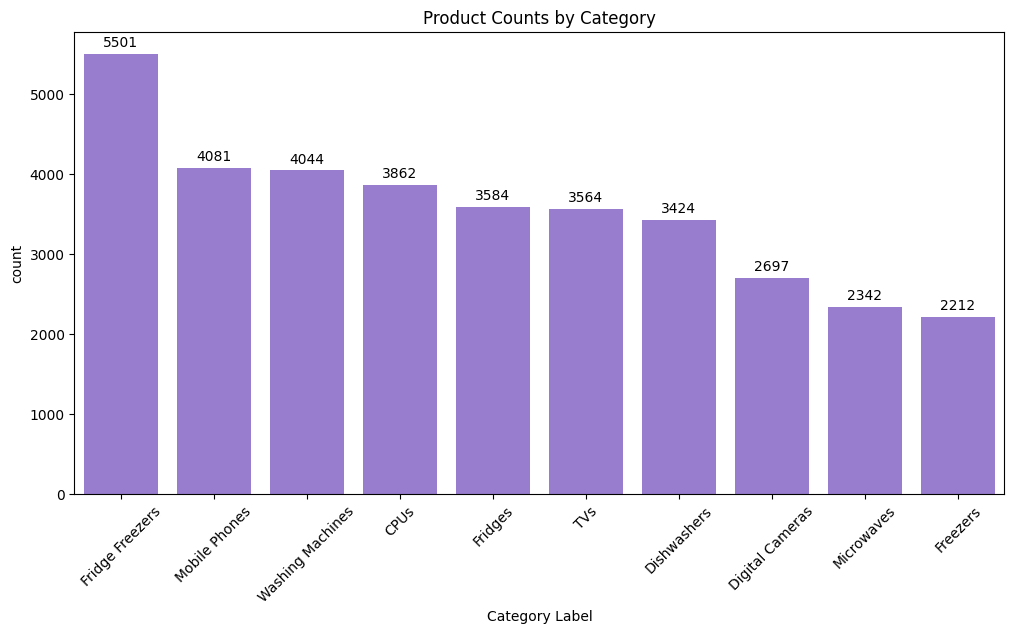

In [10]:
cat_counts = product_data['Category Label'].value_counts()
order = cat_counts.index

plt.figure(figsize=(12, 6))

ax = sns.countplot(data=product_data,
                   x='Category Label',
                   order=product_data['Category Label'].value_counts().index,
                   color='mediumpurple')
for container in ax.containers:
    ax.bar_label(container, padding=3)


plt.title('Product Counts by Category')
plt.xticks(rotation=45) 
plt.show()

In [11]:
cat_percentages = round(product_data['Category Label'].value_counts(normalize=True) * 100,2)
cat_percentages_df = pd.DataFrame(cat_percentages, columns=['proportion'])
cat_percentages_df

,proportion
Category Label,
Fridge Freezers,15.58
Mobile Phones,11.56
Washing Machines,11.45
CPUs,10.94
Fridges,10.15
TVs,10.09
Dishwashers,9.70
Digital Cameras,7.64
Microwaves,6.63


#### Summary of Category Breakdown

We can see from the bar chart and table that the Fridge Freezer category makes up the largest proportion in the dataset, over double the smallest category, Freezers. 

### Product Title

Next, we will inspect the words counts of the Product Title, the field we will be using to cluster, and we will look at this from the perspective of the category. Our goal is to attempt to answer the question, is there a difference in word counts between categories? We will build a function that does minimal cleaning by making all letters lower case, then finds the most common word in the category, the average word count, unique word count and finally total products.

In [12]:
def text_stats(texts):
    all_words = ' '.join(texts).lower().split()
    word_counts = texts.apply(lambda x: len(x.split()))
    
    most_common_word = Counter(all_words).most_common(1)[0][0] if all_words else None
    
    return pd.Series({
        'Avg Word Count': word_counts.mean(),
        'Most Common Word': most_common_word,
        'Unique Word Count': len(set(all_words)),
        'Total Products': len(texts)
    })

#### Word Summary Statistics By Category

In [13]:
category_stats = product_data.groupby('Category Label')['Product Title'].apply(text_stats).reset_index()
cat_stats_df_long = pd.DataFrame(category_stats)
cat_stats_df_wide = cat_stats_df_long.pivot(index='Category Label', columns='level_1', values='Product Title')
cat_stats_df_wide.columns.name = None 
cat_stats_df_wide['Uniq_Prod_Ratio'] = round(cat_stats_df_wide['Unique Word Count']/cat_stats_df_wide['Total Products'],2)
cat_stats_df_wide.sort_values(by='Avg Word Count', ascending=False, inplace = True)

In [14]:
cat_stats_df_wide

,Avg Word Count,Most Common Word,Total Products,Unique Word Count,Uniq_Prod_Ratio
Category Label,,,,,
CPUs,12.417141,intel,3862,2566,0.664423
TVs,10.247475,tv,3564,3039,0.852694
Digital Cameras,9.619577,camera,2697,1782,0.660734
Mobile Phones,8.547415,sim,4081,3134,0.767949
Fridge Freezers,8.184148,fridge,5501,3788,0.688602
Washing Machines,7.81998,washing,4044,2390,0.590999
Microwaves,7.652007,microwave,2342,1700,0.725875
Fridges,7.493862,fridge,3584,2814,0.785156
Freezers,7.212477,freezer,2212,1804,0.815552


#### Summary of Word Summary Statistics By Category
The spread for average word count is roughly 5.6 with approximately 12.4 words on average for the CPU category and 6.8 words on average for the dishwashers category. The most common words within categories often align to the category names themselves and when they don't like in the case of intel and sim, it is still easy to attribute the term to its category. Interestingly, TVs have the highest ratio of unique words to products, perhaps this is because there are many features of a TV that could be included in the Product Title? On the flipside, Washing Machines have the lowest unique words to product and in that same vein perhaps this is because there is only so many features or terms to use in describing a washing machine.

#### Check Distribution of Word Count Within Categories 
Now that we have an overarching look at the summary statistics around word count by category. Let's examine the within category distribution of word count. We will begin with a simple boxplot of each category and then further explore the potential outliers and what that may mean for our dataset.

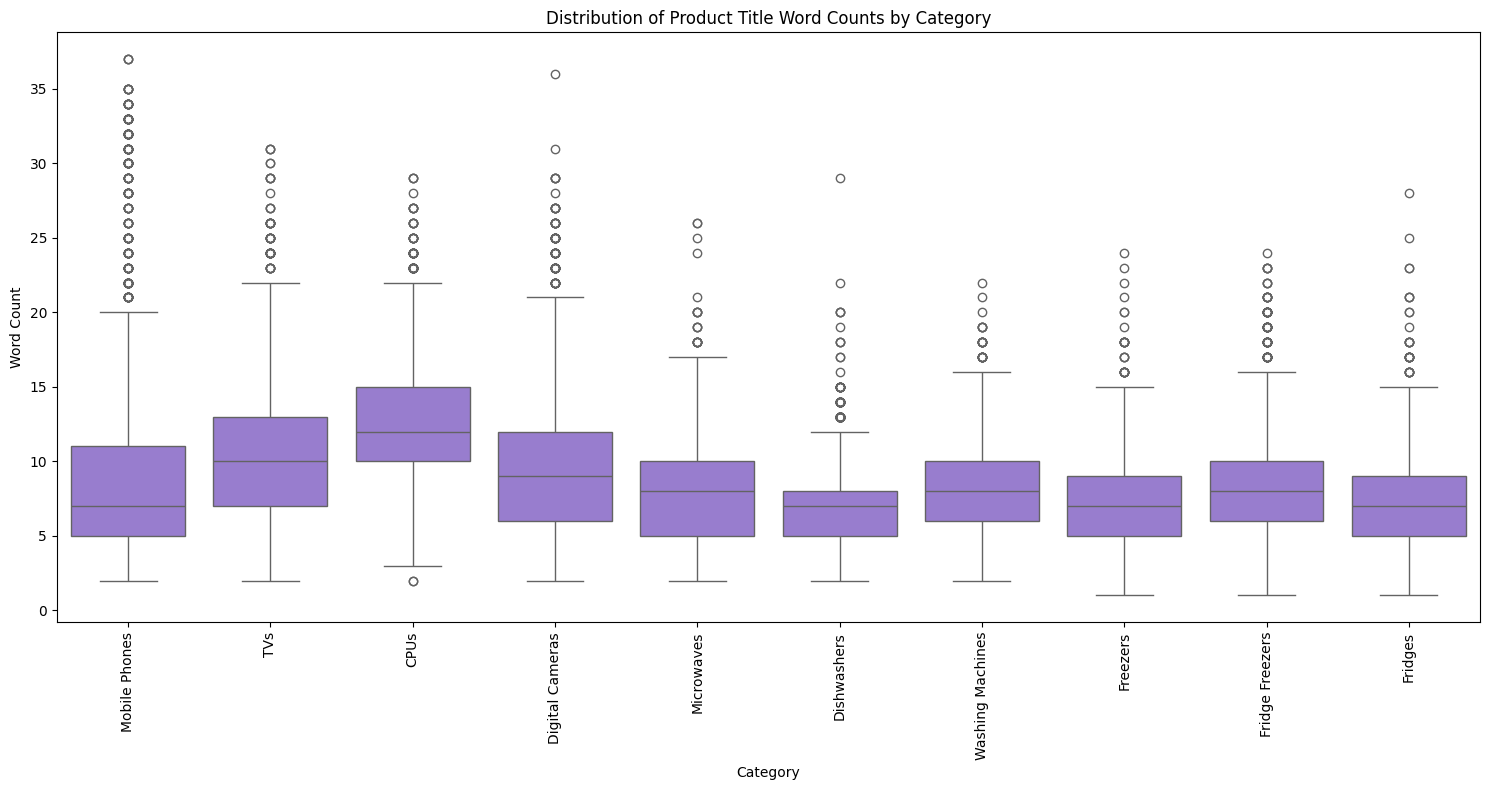

In [15]:
product_data['word_count'] = product_data['Product Title'].apply(lambda x: len(x.split()))
plt.figure(figsize=(15,8))

sns.boxplot(
    data=product_data,
    x='Category Label',    
    y='word_count',
    color='mediumpurple'
)

plt.xticks(rotation=90)
plt.title('Distribution of Product Title Word Counts by Category')
plt.xlabel('Category')
plt.ylabel('Word Count')
plt.tight_layout()
plt.show()

##### Identify Outliers within Categories

We can see from the boxplot that some categories have a small spread when it comes to word count, for example dishwashers and freezers whereas others like mobile phones and TVs appear to have large spreads. In addition, there are categories that appear to be evenly distributed when it comes to average word count such as washing machines and fridge freezers, whereas others appear skewed for instance microwaves and CPUs.

While CPUs appears to have one outlier on the low end of the word count, the vast majority of outliers for categories appear to be on the high end of word count. We will explore these further to see if there are any themes to be found.

We will apply a function that finds the outliers for each group. The function uses the standard formula for the lower bound of $Q1-1.5*IQR$ where Q1 is the first quartile and IQR is the inner quartile range. Likewise the upper bound will be found with the standard formula of $Q3+1.5*IQR$.

In [16]:
def find_outliers(group):
    Q1 = np.percentile(group['word_count'], 25)
    Q3 = np.percentile(group['word_count'], 75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return group[(group['word_count'] < lower_bound) | (group['word_count'] > upper_bound)]

In [17]:
outliers_df = product_data.groupby('Category Label', group_keys=False).apply(find_outliers).reset_index(drop=True)
outliers_df

/var/folders/zb/qqs6287175b895ccv4xrsthm0000gn/T/ipykernel_75273/3128954913.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  outliers_df = product_data.groupby('Category Label', group_keys=False).apply(find_outliers).reset_index(drop=True)


,Product ID,Product Title,Merchant ID,Cluster ID,Cluster Label,Category ID,Category Label,word_count
0,13965,intel core i9 7960x 2.8 ghz skylake x sockel 2...,36,5869,Intel Core i9 7960X 2.8GHz Box,2615,CPUs,24
1,14325,intel pentium gold g5400 3.7ghz dual core 4 th...,3,5925,Intel Pentium Gold G5400 3.7GHz Box,2615,CPUs,26
2,14383,intel xeon e3 1245 3 7 ghz skt 1151 kaby lake ...,36,5940,Intel Xeon E3-1245 V6 3.7GHz Box,2615,CPUs,23
3,14485,intel cpu lga1151 core i5 7600k tray 3.8ghz 6m...,36,5968,Intel Core i5-7600K 3.80GHz Tray,2615,CPUs,24
4,14488,intel core i3 7350k 4200 1151 tray i3 4.2 ghz ...,36,5969,Intel Core i3-7350K 4.2GHz Tray,2615,CPUs,26
...,...,...,...,...,...,...,...,...
623,33950,beko wmb91243lb freestanding front load 9kg 12...,3,42570,Beko WMB91243LB,2620,Washing Machines,17
624,34385,avensys bosch wae28262gb capacity 6kg 1400 rpm...,168,42826,Bosch WAE28262GB,2620,Washing Machines,17
625,34514,b ware aeg waschmaschinen l7fe76484 8kg 368778...,297,42966,AEG L7FE76484,2620,Washing Machines,18
626,34572,bosch wlg24160by freestanding front load 5kg 1...,17,43049,Bosch WLG24160BY,2620,Washing Machines,17


#### Inspecting the Outlier Dataframe
We can see from the outlier dataframe that there are 628 total outliers within the 10 categories. Let's explore the distribution of the outliers across categories. Our goal with this is to determine if there are certain categories where outliers may be of concern. 

In [18]:
total_counts = product_data['Category Label'].value_counts()
outlier_counts = outliers_df['Category Label'].value_counts()

total_counts_df = total_counts.reset_index()
total_counts_df.columns = ['Category Label', 'total_products']

outlier_counts_df = outlier_counts.reset_index()
outlier_counts_df.columns = ['Category Label', 'outlier_products']

counts_df = total_counts_df.merge(outlier_counts_df, on='Category Label', how='left')
counts_df['outlier_percent'] = (counts_df['outlier_products'] / counts_df['total_products']) * 100
counts_df

,Category Label,total_products,outlier_products,outlier_percent
0,Fridge Freezers,5501,71,1.290674
1,Mobile Phones,4081,184,4.508699
2,Washing Machines,4044,24,0.593472
3,CPUs,3862,63,1.631279
4,Fridges,3584,29,0.809152
5,TVs,3564,49,1.374860
6,Dishwashers,3424,91,2.657710
7,Digital Cameras,2697,73,2.706711
8,Microwaves,2342,19,0.811272
9,Freezers,2212,25,1.130199


<Figure size 1200x600 with 0 Axes>

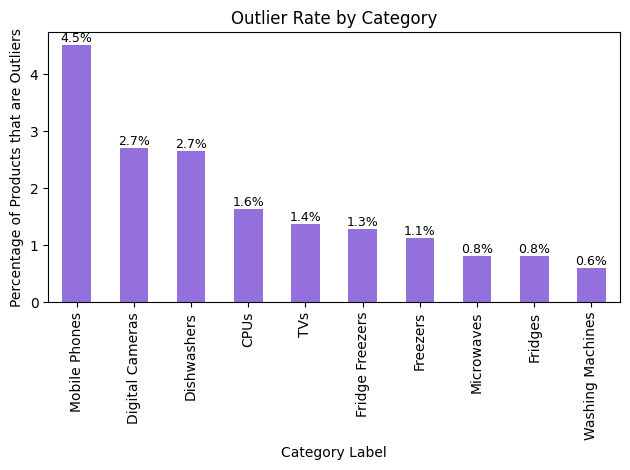

In [19]:
plt.figure(figsize=(12,6))

ax = counts_df.sort_values('outlier_percent', ascending=False).plot(
    x='Category Label',
    y='outlier_percent',
    kind='bar',
    legend=False,
    color = 'mediumpurple'
)

plt.ylabel('Percentage of Products that are Outliers')
plt.title('Outlier Rate by Category')
plt.tight_layout()

for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', 
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=9, color='black')

plt.show()


#### Summary of Outlier Rate by Category
While mobile phones has the highest percentage of product titles being outliers within the category, ie 4.5% of mobile phone product titles are outliers, it's not an alarming percentage. Let's further investigate the outliers to determine if they are merchant specific or evenly spread across merchants. We will do this by building a chart that shows the product outliers by Merchant ID and Category Label together. 

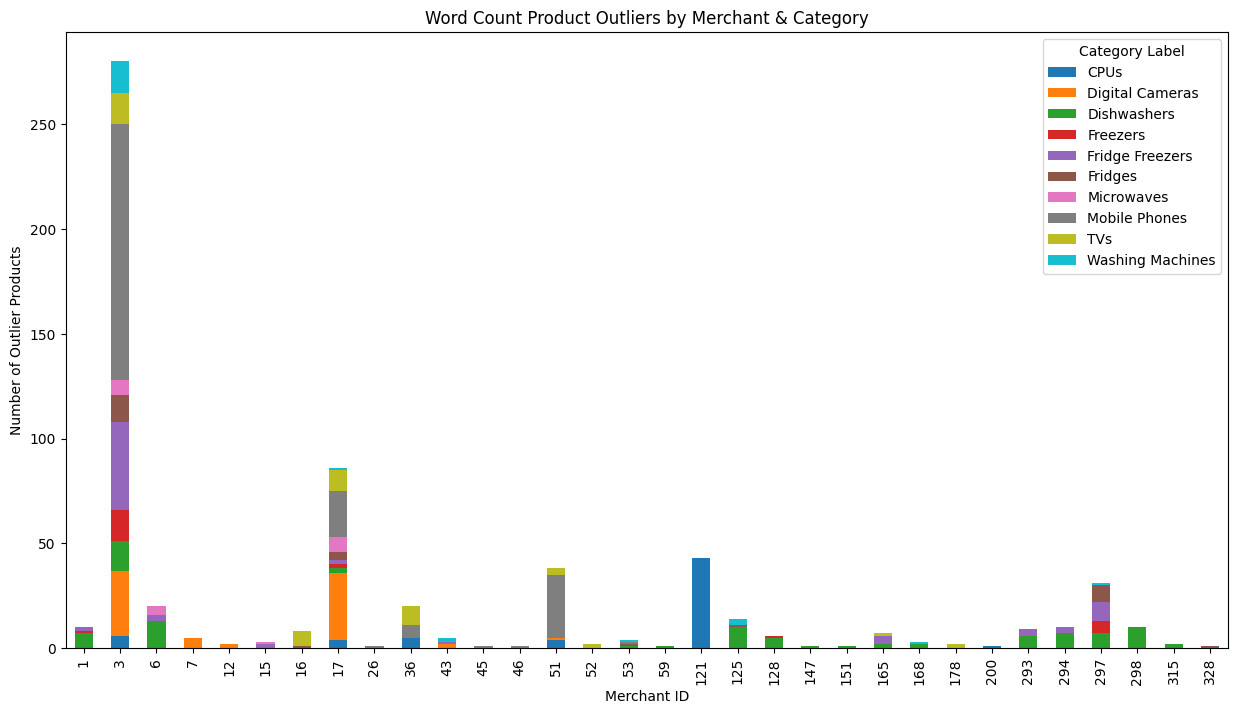

In [20]:
outlier_merch_counts = (
    outliers_df.groupby(['Merchant ID', 'Category Label'])
    .size()
    .unstack(fill_value=0)
)

outlier_merch_counts.plot(kind='bar', stacked=True, figsize=(15,8))
plt.title('Word Count Product Outliers by Merchant & Category')
plt.ylabel('Number of Outlier Products')
plt.xticks(rotation=90)
plt.show()

In [21]:
outlier_merch_counts['Total_Outliers'] = outlier_merch_counts.sum(axis=1)
total_sum = outlier_merch_counts['Total_Outliers'].sum()
outlier_merch_counts['Percentage_Of_TTl'] = round(outlier_merch_counts['Total_Outliers']/total_sum*100,2)
outlier_merch_counts.sort_values(by='Percentage_Of_TTl', ascending=False, inplace = True)
outlier_merch_counts

Category Label,CPUs,Digital Cameras,Dishwashers,Freezers,Fridge Freezers,Fridges,Microwaves,Mobile Phones,TVs,Washing Machines,Total_Outliers,Percentage_Of_TTl
Merchant ID,,,,,,,,,,,,
3,6,31,14,15,42,13,7,122,15,15,280,44.59
17,4,32,2,2,2,4,7,22,10,1,86,13.69
121,43,0,0,0,0,0,0,0,0,0,43,6.85
51,4,1,0,0,0,0,0,30,3,0,38,6.05
297,0,0,7,6,9,8,0,0,0,1,31,4.94
6,0,0,13,0,3,0,4,0,0,0,20,3.18
36,5,0,0,0,0,0,0,6,9,0,20,3.18
125,0,0,10,0,0,1,0,0,0,3,14,2.23
298,0,0,10,0,0,0,0,0,0,0,10,1.59


In [22]:
#Mobile Phone Percent Within Merchant 3
122/280*100

43.57142857142857

#### Summary of Merchant Outliers 
Merchant 3 has the largest portion of the outliers with 44.59% of total outliers being from this merchant. In addition, the largest category for outliers within Merchant 3 is mobile phones which makes up  43.57% of Merchant 3's outliers. However, this could all be potentially due to Merchant 3 selling lots of different mobile phones. 


#### By Category Outlier Rate
To further investigate if these outlier rates are truly of a concern, we're going to calculate a by category outlier rate for each of the merchants and determine if Merchant 3's rate is higher than their peers.

In [23]:
total_counts_merch_cat = (
    product_data.groupby(['Merchant ID', 'Category Label'])
    .size()
    .reset_index(name='total_products')
)
total_counts_merch_cat.head()

,Merchant ID,Category Label,total_products
0,1,Digital Cameras,20
1,1,Dishwashers,18
2,1,Freezers,12
3,1,Fridge Freezers,78
4,1,Fridges,14


In [24]:
outlier_counts_merch_cat = (
    outliers_df.groupby(['Merchant ID', 'Category Label'])
    .size()
    .reset_index(name='outlier_products')
)
outlier_counts_merch_cat.head()

,Merchant ID,Category Label,outlier_products
0,1,Dishwashers,7
1,1,Freezers,1
2,1,Fridge Freezers,2
3,3,CPUs,6
4,3,Digital Cameras,31


In [25]:
counts_cat_merch_df = total_counts_merch_cat.merge(outlier_counts_merch_cat, 
                               on=['Merchant ID', 'Category Label'], 
                               how='left')

counts_cat_merch_df['outlier_products'] = counts_cat_merch_df['outlier_products'].fillna(0)
counts_cat_merch_df['outlier_percent'] = (counts_cat_merch_df['outlier_products'] / counts_cat_merch_df['total_products']) * 100

We are going to filter this data to only those merchants that have an outlier in the category. This way we can zero in on the areas of potential concern and more easily compare across merchants.

In [26]:
heatmap_data = counts_cat_merch_df[counts_cat_merch_df['outlier_products'] > 0]

pivot = heatmap_data.pivot(index='Merchant ID', columns='Category Label', values='outlier_percent')


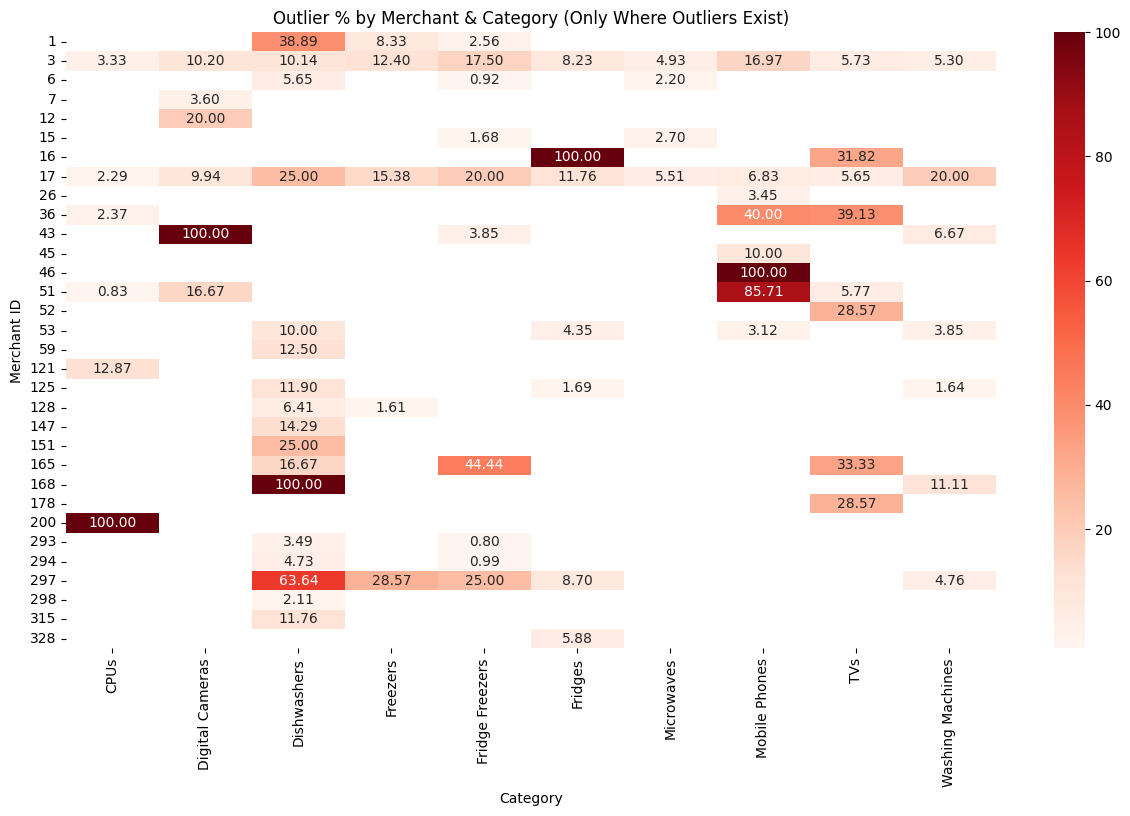

In [27]:
plt.figure(figsize=(15,8))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap='Reds')

plt.title('Outlier % by Merchant & Category (Only Where Outliers Exist)')
plt.ylabel('Merchant ID')
plt.xlabel('Category')
plt.show()


From our heatmap, we can see that there are some merchants with a large percentage of outliers, but we are still not sure if this is of concern. It's possible that a merchant might only sell outliers resulting in 100% in the heatmap, but they also only sell 5 products, in which case it wouldn't be relevant since we have so many products in our dataset. We will filter the heatmap data to those with an outlier percentage of 20% or higher to determine if we need to take any steps to remedy the data. 

In [28]:
lg_outlier_percents = heatmap_data[heatmap_data['outlier_percent'] > 20]
lg_outlier_percents.sort_values(by='total_products', ascending=False)

,Merchant ID,Category Label,total_products,outlier_products,outlier_percent
696,297,Fridge Freezers,36,9.0,25.000000
207,51,Mobile Phones,35,30.0,85.714286
167,36,TVs,23,9.0,39.130435
89,16,TVs,22,7.0,31.818182
695,297,Freezers,21,6.0,28.571429
1,1,Dishwashers,18,7.0,38.888889
166,36,Mobile Phones,15,6.0,40.000000
694,297,Dishwashers,11,7.0,63.636364
523,165,Fridge Freezers,9,4.0,44.444444
92,17,Dishwashers,8,2.0,25.000000


#### Summary of Outlier Rate

From the heatmap we can clearly see that Merchant 3's outlier rate is under 20% for all categories. The assumption that maybe they sell a lot of products and thus that is why they were overrepresented in the outlier data appears to be correct. Further inspection of those merchant-category combinations that did have higher than 20% yielded the insight that none of them had more than 36 total products, which is quite small in context of the dataset.

In [29]:
#Percentage of Merchants with Outliers
outlier_merchants = len(outlier_merch_counts)
total_merchants = product_data['Merchant ID'].nunique()
percent_outlier_merchants = round(outlier_merchants/total_merchants*100,2)
percent_outlier_merchants

10.46

### Summary of Outliers
Based on this exploration, it is safe to say that the outliers within categories are not evenly distributed amongst merchants, roughly only 10.5% of merchants had a product title that was considered an outlier within its category; in addition the majority of product title outliers came from Merchant 3. However, we've been able to confirm that even though Merchant 3 had the majority of the outliers, their rate of outliers by category was not higher than other merchants leading to the conclusion that Merchant 3 is overrepresented in the outlier data purely because they sell more products. 

Lets take one final look at the outliers by category and compare their word counts to those that are not outliers. We aim to answer the question how are the outliers different from the non-outliers in their category? 

### Word Count Statistics for Outliers vs. Non-Outliers

We will begin by creating non-outliers dataframe to compare to the existing outliers dataframe. 

In [30]:
nonoutliers_df = product_data.merge(
    outliers_df,
    how='left',
    indicator=True
)

nonoutliers_df = nonoutliers_df[nonoutliers_df['_merge'] == 'left_only'].drop(columns=['_merge'])

In [31]:
len(nonoutliers_df) + len(outliers_df)

35311

In [32]:
len(product_data)

35311

We would like to look at a comparison of the average word count, most common word and unique word count between the groups. In order to do this, we will create a single dataframe of both outliers and non-outliers that showcases the by category differences in these statistics.

In [33]:
nonoutlier_stats = nonoutliers_df.groupby('Category Label')['Product Title'].apply(text_stats).reset_index()
nonoutlier_stats_df_long = pd.DataFrame(nonoutlier_stats)
nonoutlier_stats_df_wide = nonoutlier_stats_df_long.pivot(index='Category Label', columns='level_1', values='Product Title')
nonoutlier_stats_df_wide.columns.name = None 

In [35]:
outlier_stats = outliers_df.groupby('Category Label')['Product Title'].apply(text_stats).reset_index()
outlier_stats_df_long = pd.DataFrame(outlier_stats)
outlier_stats_df_wide = outlier_stats_df_long.pivot(index='Category Label', columns='level_1', values='Product Title')
outlier_stats_df_wide.columns.name = None 

In [37]:
Avg_Word_Count_Diff = round(outlier_stats_df_wide['Avg Word Count'] - nonoutlier_stats_df_wide['Avg Word Count'],2)
Percent_Word_Count_Diff = round(
    ((outlier_stats_df_wide['Avg Word Count'] - nonoutlier_stats_df_wide['Avg Word Count']) /
     nonoutlier_stats_df_wide['Avg Word Count']) * 100, 2)
Uniq_Word_Ratio_Non = round(nonoutlier_stats_df_wide['Unique Word Count']/nonoutlier_stats_df_wide['Total Products'],2)
Uniq_Word_Ratio_Out = round(outlier_stats_df_wide['Unique Word Count']/outlier_stats_df_wide['Total Products'], 2)
Uniq_Word_Ratio_Diff = Uniq_Word_Ratio_Out - Uniq_Word_Ratio_Non
Same_Most_Common_Word = outlier_stats_df_wide['Most Common Word'] == nonoutlier_stats_df_wide['Most Common Word']

Comparison_Table = pd.DataFrame({
    'Avg Word Count Diff': Avg_Word_Count_Diff,
    'Avg Word Percent Diff': Percent_Word_Count_Diff,
    'Unique Word Ratio Non-Outlier': Uniq_Word_Ratio_Non,
    'Unique Word Ratio Outlier': Uniq_Word_Ratio_Out,
    'Unique Word Ratio Difference': Uniq_Word_Ratio_Diff,
    'Same Most Common Word': Same_Most_Common_Word
})
pd.set_option('display.float_format', '{:.2f}'.format)
Comparison_Table

,Avg Word Count Diff,Avg Word Percent Diff,Unique Word Ratio Non-Outlier,Unique Word Ratio Outlier,Unique Word Ratio Difference,Same Most Common Word
Category Label,,,,,,
CPUs,11.50,94.04,0.65,5.86,5.20,False
Digital Cameras,15.54,168.94,0.64,5.11,4.47,True
Dishwashers,7.77,117.63,0.65,3.98,3.32,True
Freezers,11.07,156.23,0.80,7.76,6.96,False
Fridge Freezers,11.16,138.77,0.67,5.14,4.47,False
Fridges,11.32,152.95,0.77,7.86,7.09,False
Microwaves,12.71,168.43,0.73,5.53,4.80,True
Mobile Phones,20.09,262.93,0.72,4.80,4.08,False
TVs,15.68,156.33,0.84,6.63,5.80,True


#### Summary of Word Count Statistics - Outliers vs. Non-Outliers
Looking at the avg word count between the two groups, there definitely appears to be a sizeable difference in every category. On the low end, the CPU category had a 94% increase in average word count in the outlier group, and on the high end, Mobile Phones saw an almost 263% increase in average word count. In addition, the unique words ratio is considerably higher in the outlier group leading one to assume that the outliers aren't just more words, but also with in the outlier group the word choice is varies a lot. 

We can further see the differences in word choice when looking at the most common word. The outlier group includes the stopword 'a' as the most common word for freezers, fridge freezers and fridges. The issue of stopwords may need to be addressed in the preprocessing stage to ensure a clean text set for clustering. Aside from the freezers, fridge freezers and fridges categories there are three additional categories where the most common word is not the same between the outlier and non-outlier groups. Those three categories are CPUs, Mobile Phones and Washing Machines. Again, this leads us to the conclusion that the word choices themselves are different between the groups for these categories and not just the word count. 

We will explore this a little further to see what the top 10 words are for each category and group. For this process, we are going to remove the stopwords; this is being done to get a purer look at the types of words being used in the Product Titles.

In [38]:
def top_10_words(category, outliers_df, nonoutliers_df):
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))

    word_freqs = {}
    for idx, (df, title) in enumerate(zip([outliers_df, nonoutliers_df], ['Outlier Products', 'Non-Outlier Products'])):
        
        subset = df[df['Category Label'] == category]
        text = ' '.join(subset['Product Title'].astype(str))
        
        vectorizer = CountVectorizer(lowercase=True, stop_words='english')
        X = vectorizer.fit_transform([text])
        word_freq = dict(zip(vectorizer.get_feature_names_out(), X.toarray().sum(axis=0)))    
    
        word_freqs[title] = word_freq

    
    nonoutlier_dict = word_freqs['Non-Outlier Products']
    outlier_dict = word_freqs['Outlier Products']

    cat_df = pd.DataFrame({
    'Non-Outlier Count': nonoutlier_dict,
    'Outlier Count': outlier_dict
    })
    cat_df.fillna(0, inplace=True)

    top_10_non = cat_df['Non-Outlier Count'].nlargest(10)
    top_10_out = cat_df['Outlier Count'].nlargest(10)

    top_10_non.plot(kind='bar', ax=ax[0], color='#9370DB')
    ax[0].set_title('Top 10 Words Non-Outliers')
    ax[0].set_xlabel('Word')
    ax[0].set_ylabel('Frequency')
    
    top_10_out.plot(kind='bar', ax=ax[1], color='#9370DB')
    ax[1].set_title('Top 10 Words Outliers')
    ax[1].set_xlabel('Word')
    ax[1].set_ylabel('Frequency')


    for p in ax[0].patches:
        ax[0].annotate(
            str(int(p.get_height())), 
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='bottom', fontsize=9
        )

    for p in ax[1].patches:
        ax[1].annotate(
            str(int(p.get_height())), 
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='bottom', fontsize=9
        )

    
    plt.tight_layout()
    plt.show()

#### CPUs Top 10 Words Outlier vs. Non-Outlier

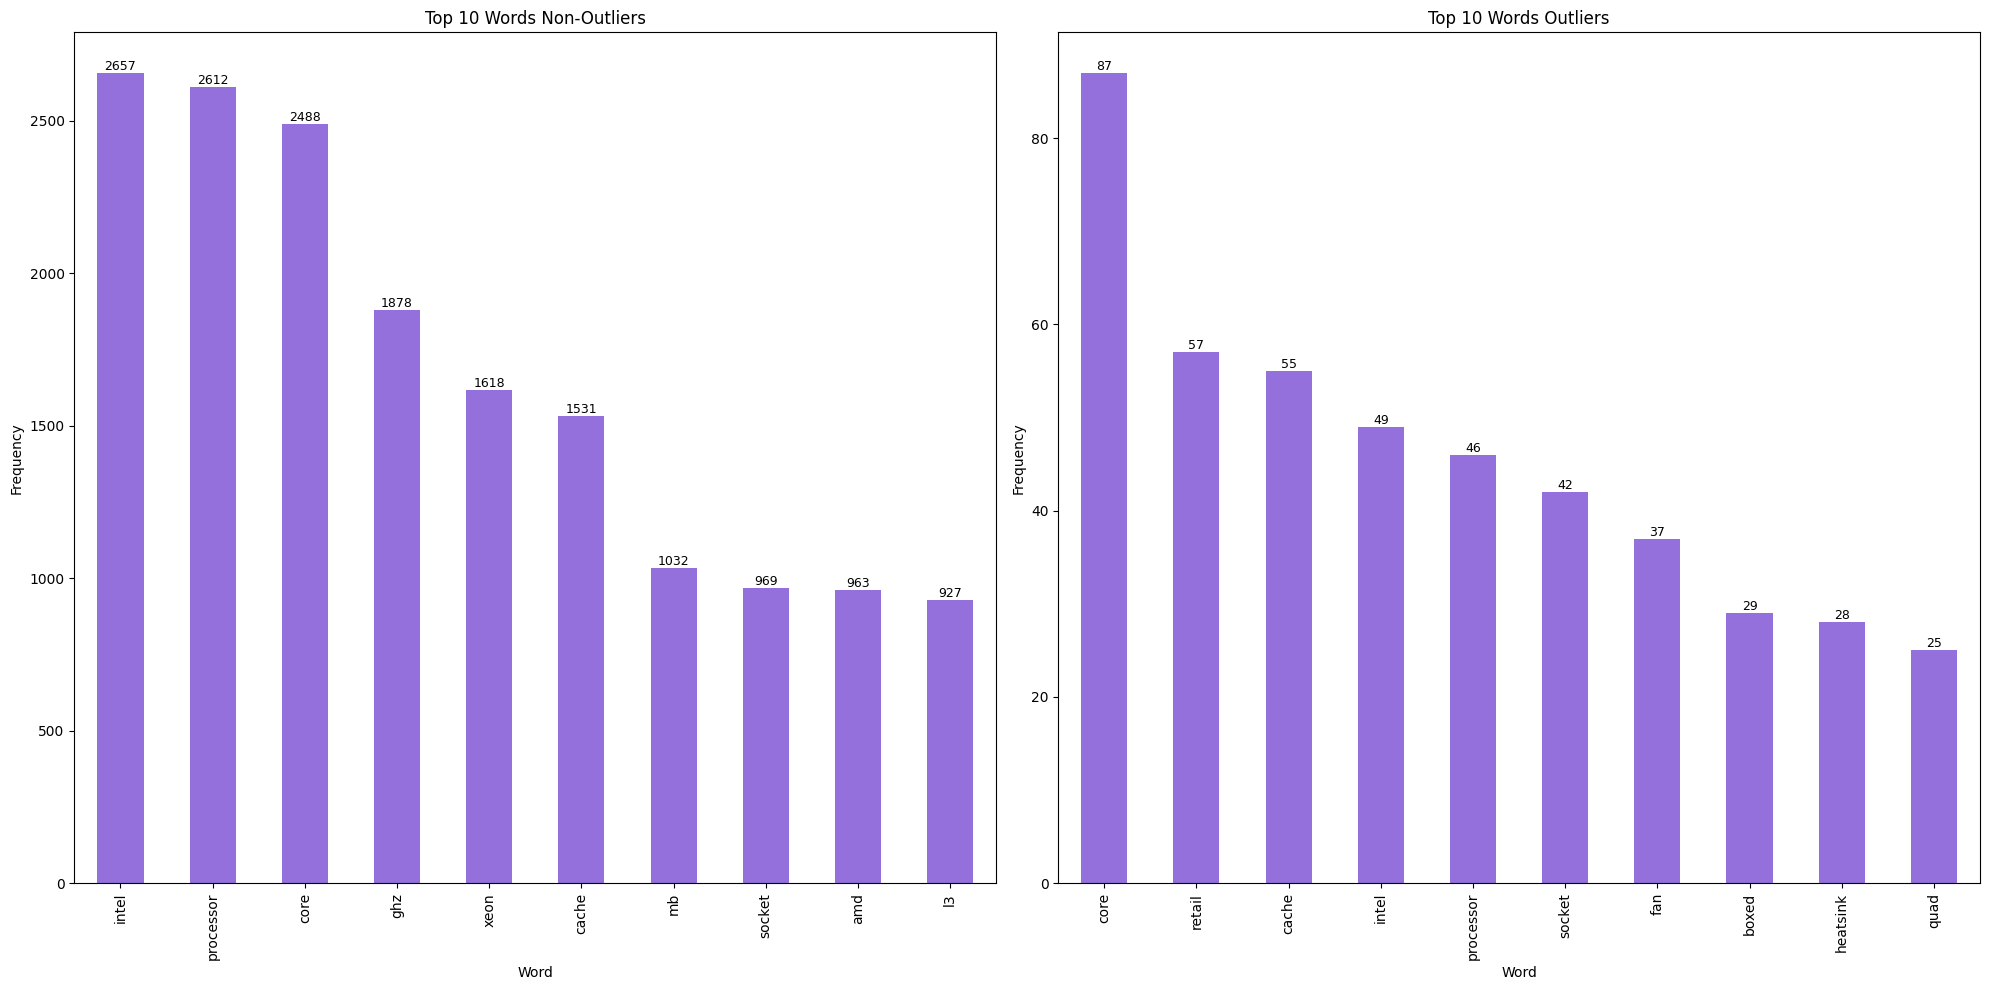

In [39]:
top_10_words('CPUs', outliers_df, nonoutliers_df)


#### Digital Cameras Top 10 Words Outlier vs. Non-Outlier

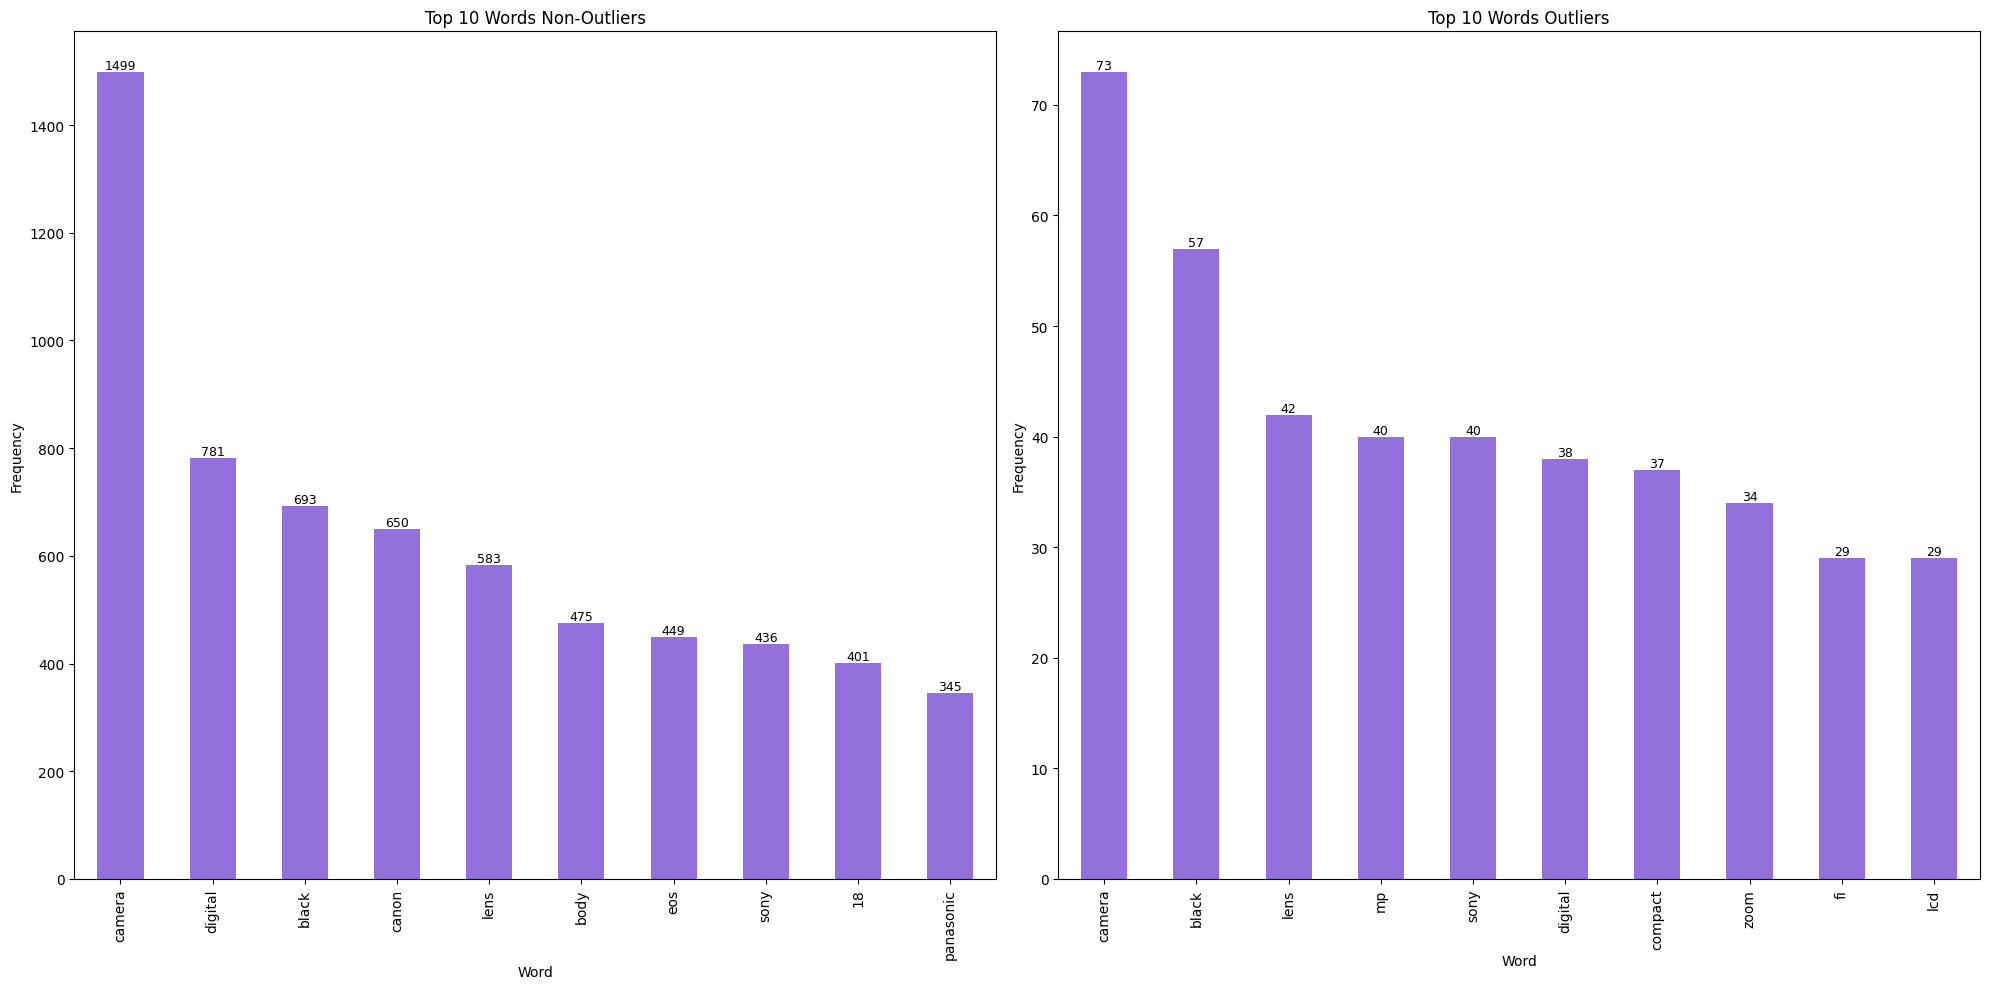

In [40]:
top_10_words('Digital Cameras', outliers_df, nonoutliers_df)

#### Dishwashers Top 10 Words Outlier vs. Non-Outlier

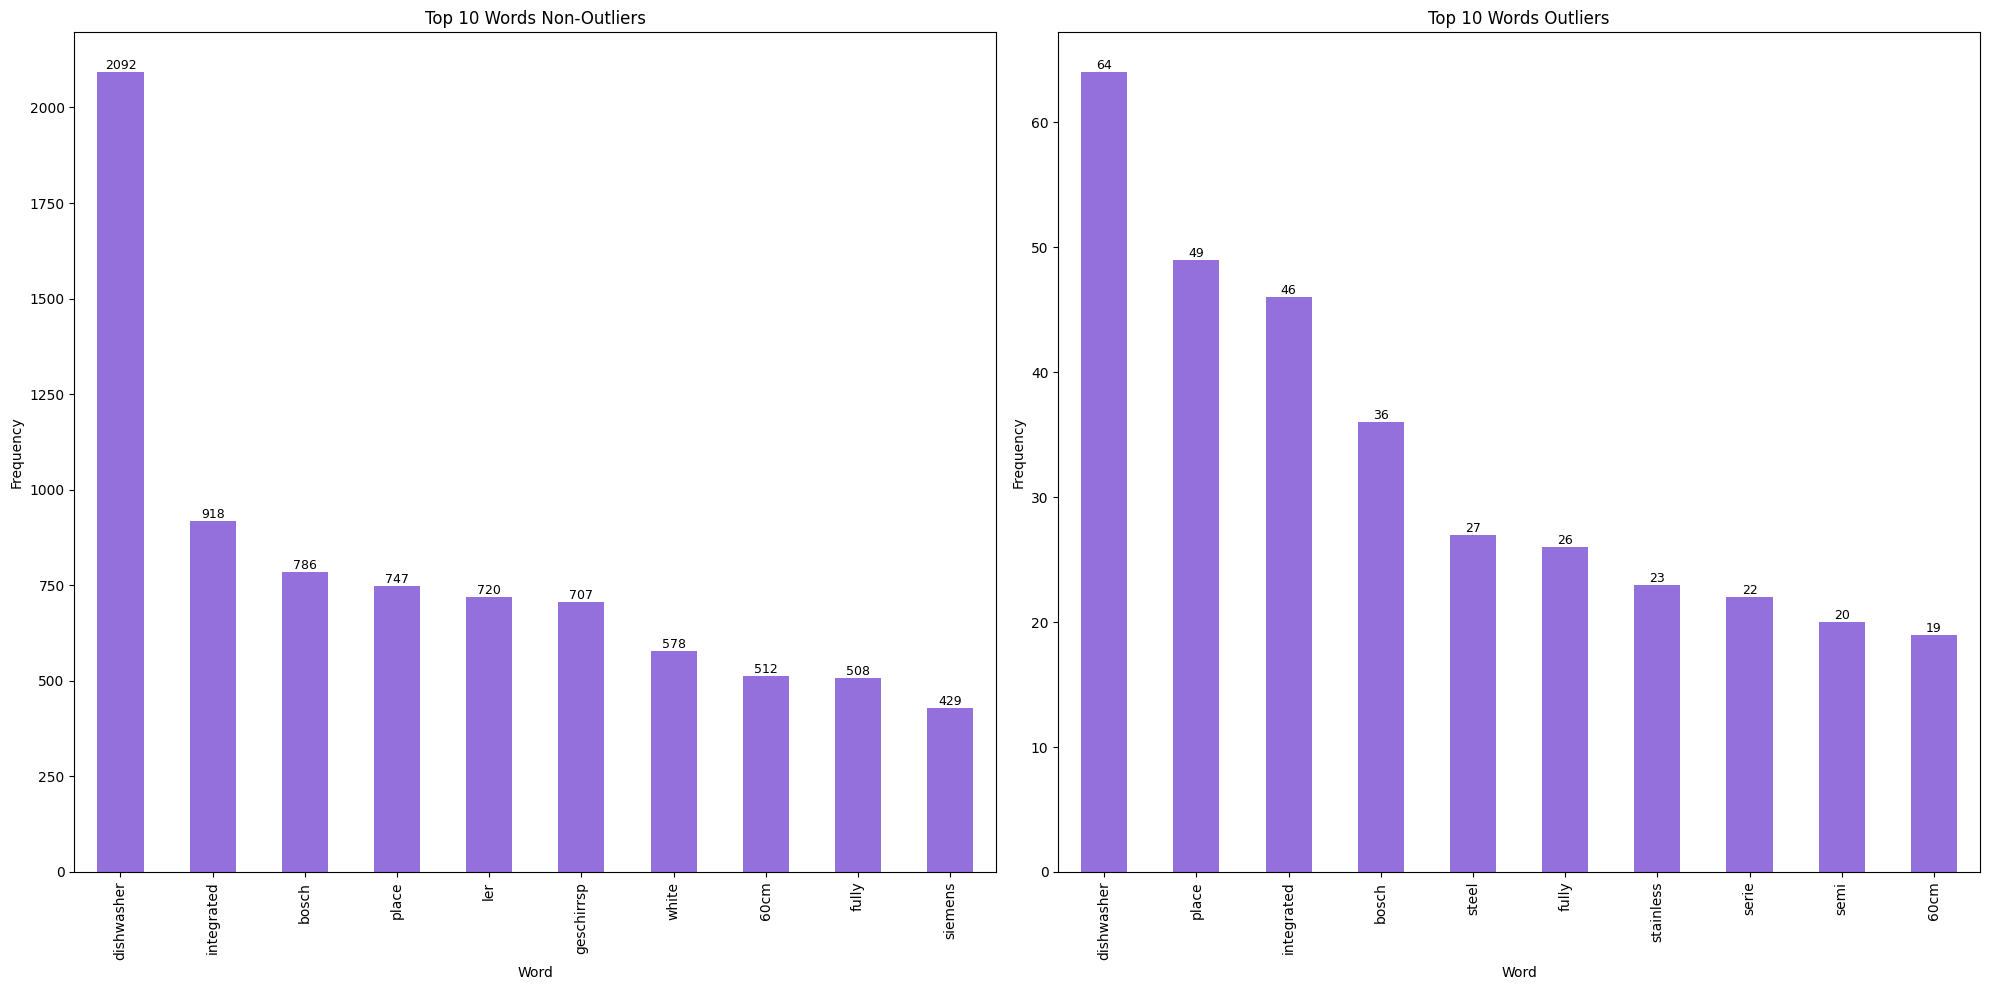

In [41]:
top_10_words('Dishwashers', outliers_df, nonoutliers_df)

#### Freezers Top 10 Words Outlier vs. Non-Outlier

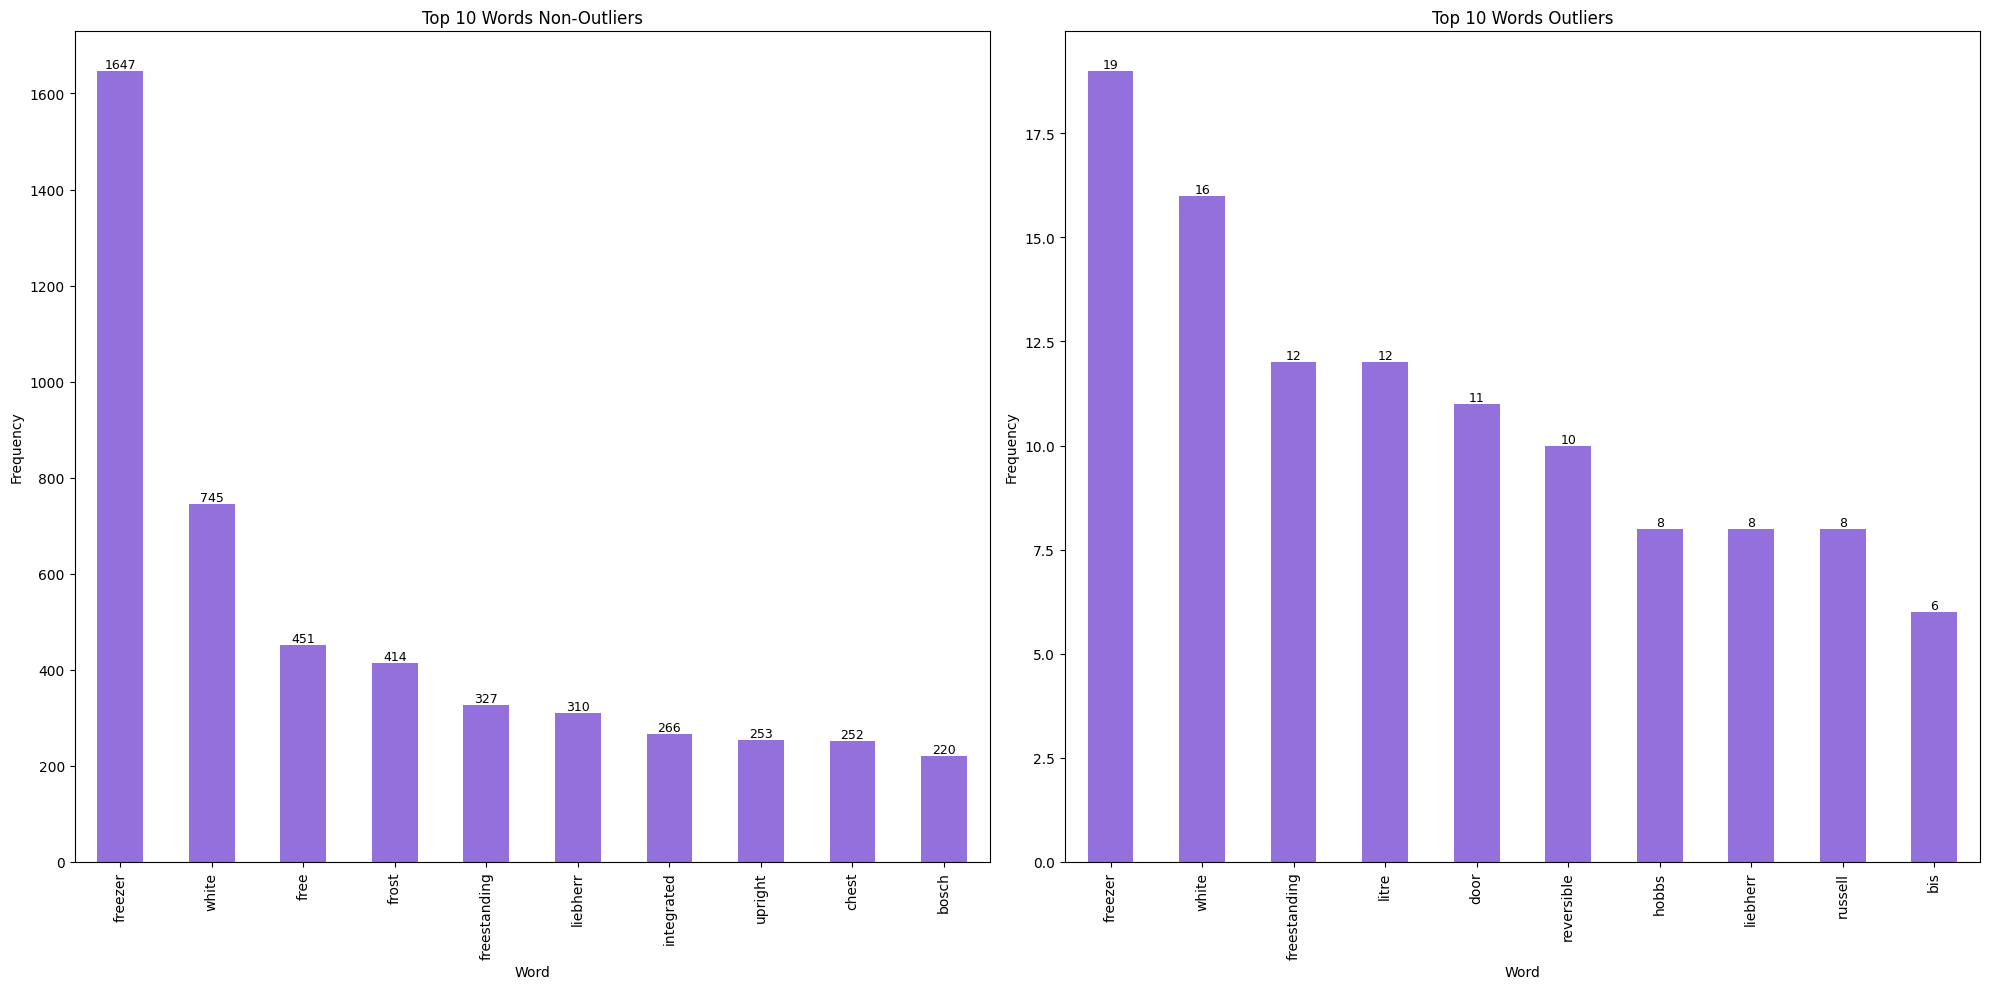

In [42]:
top_10_words('Freezers', outliers_df, nonoutliers_df)

#### Fridge Freezers Top 10 Words Outlier vs. Non-Outlier

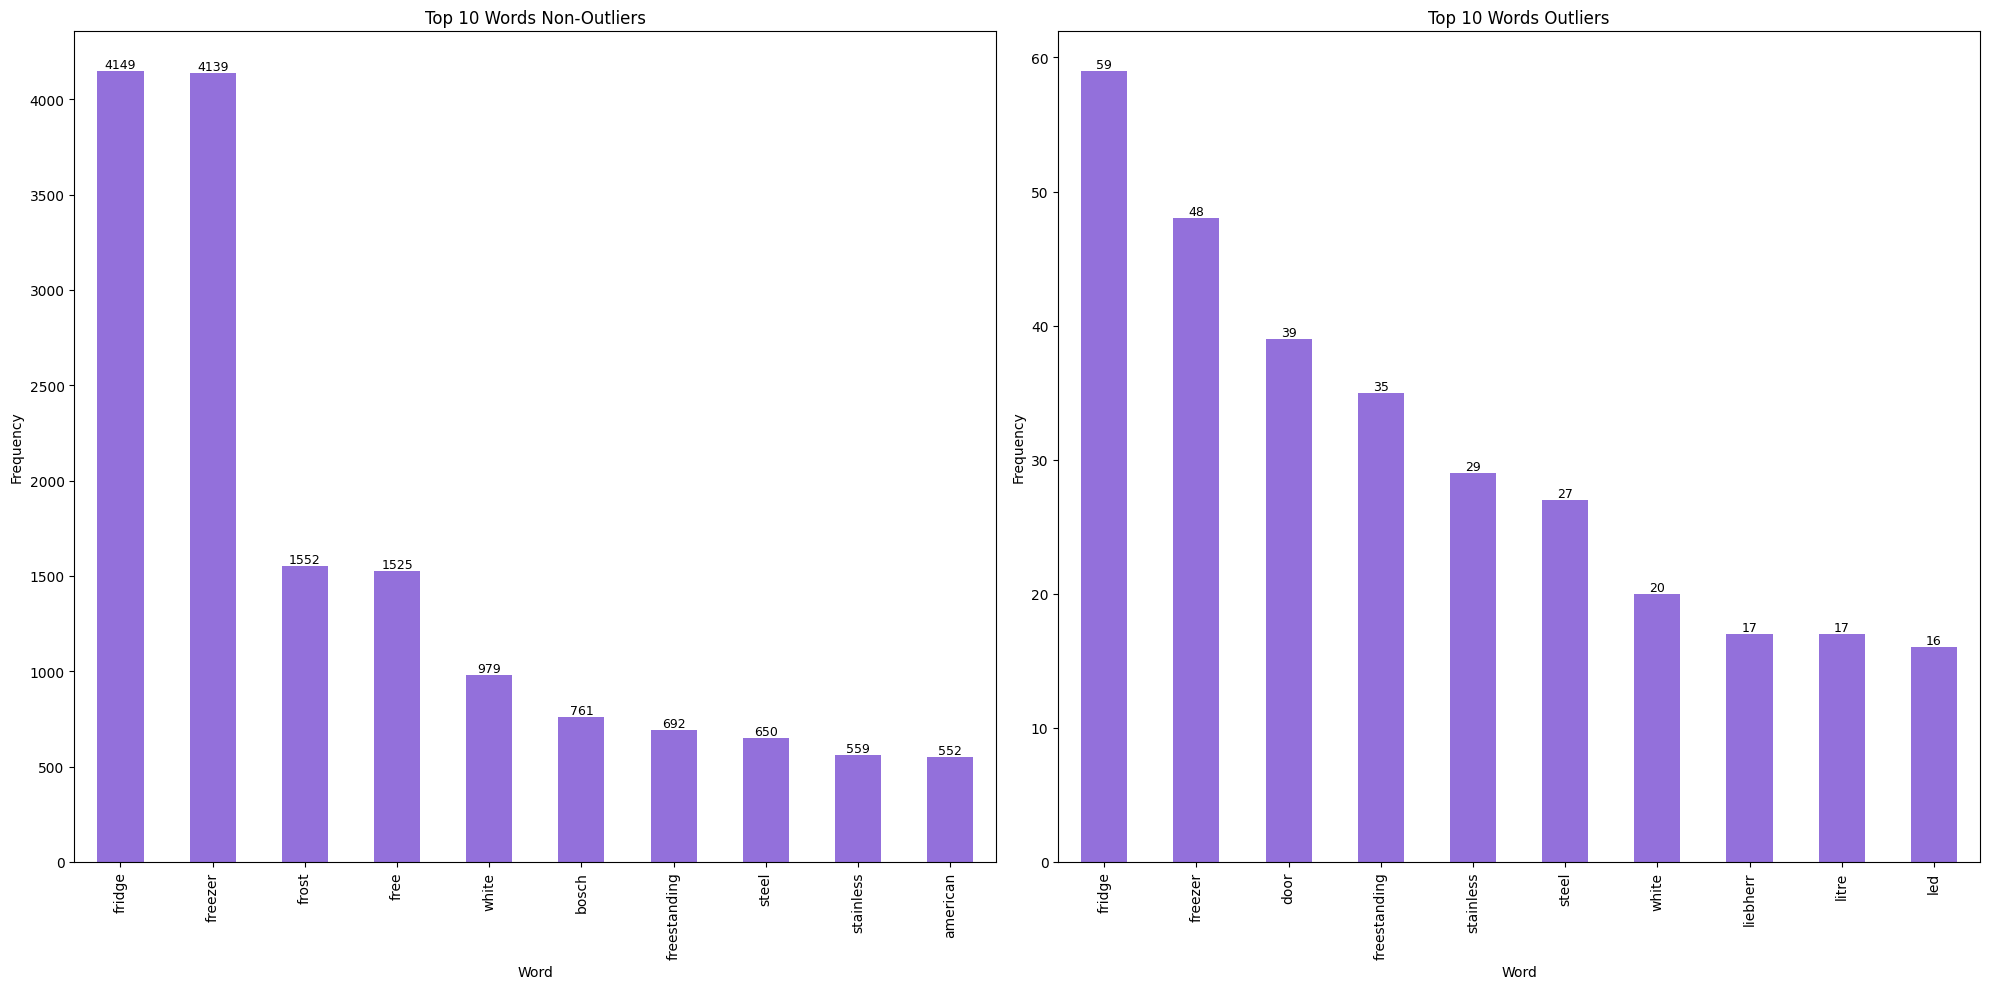

In [43]:
top_10_words('Fridge Freezers', outliers_df, nonoutliers_df)

#### Fridges Top 10 Words Outlier vs. Non-Outlier

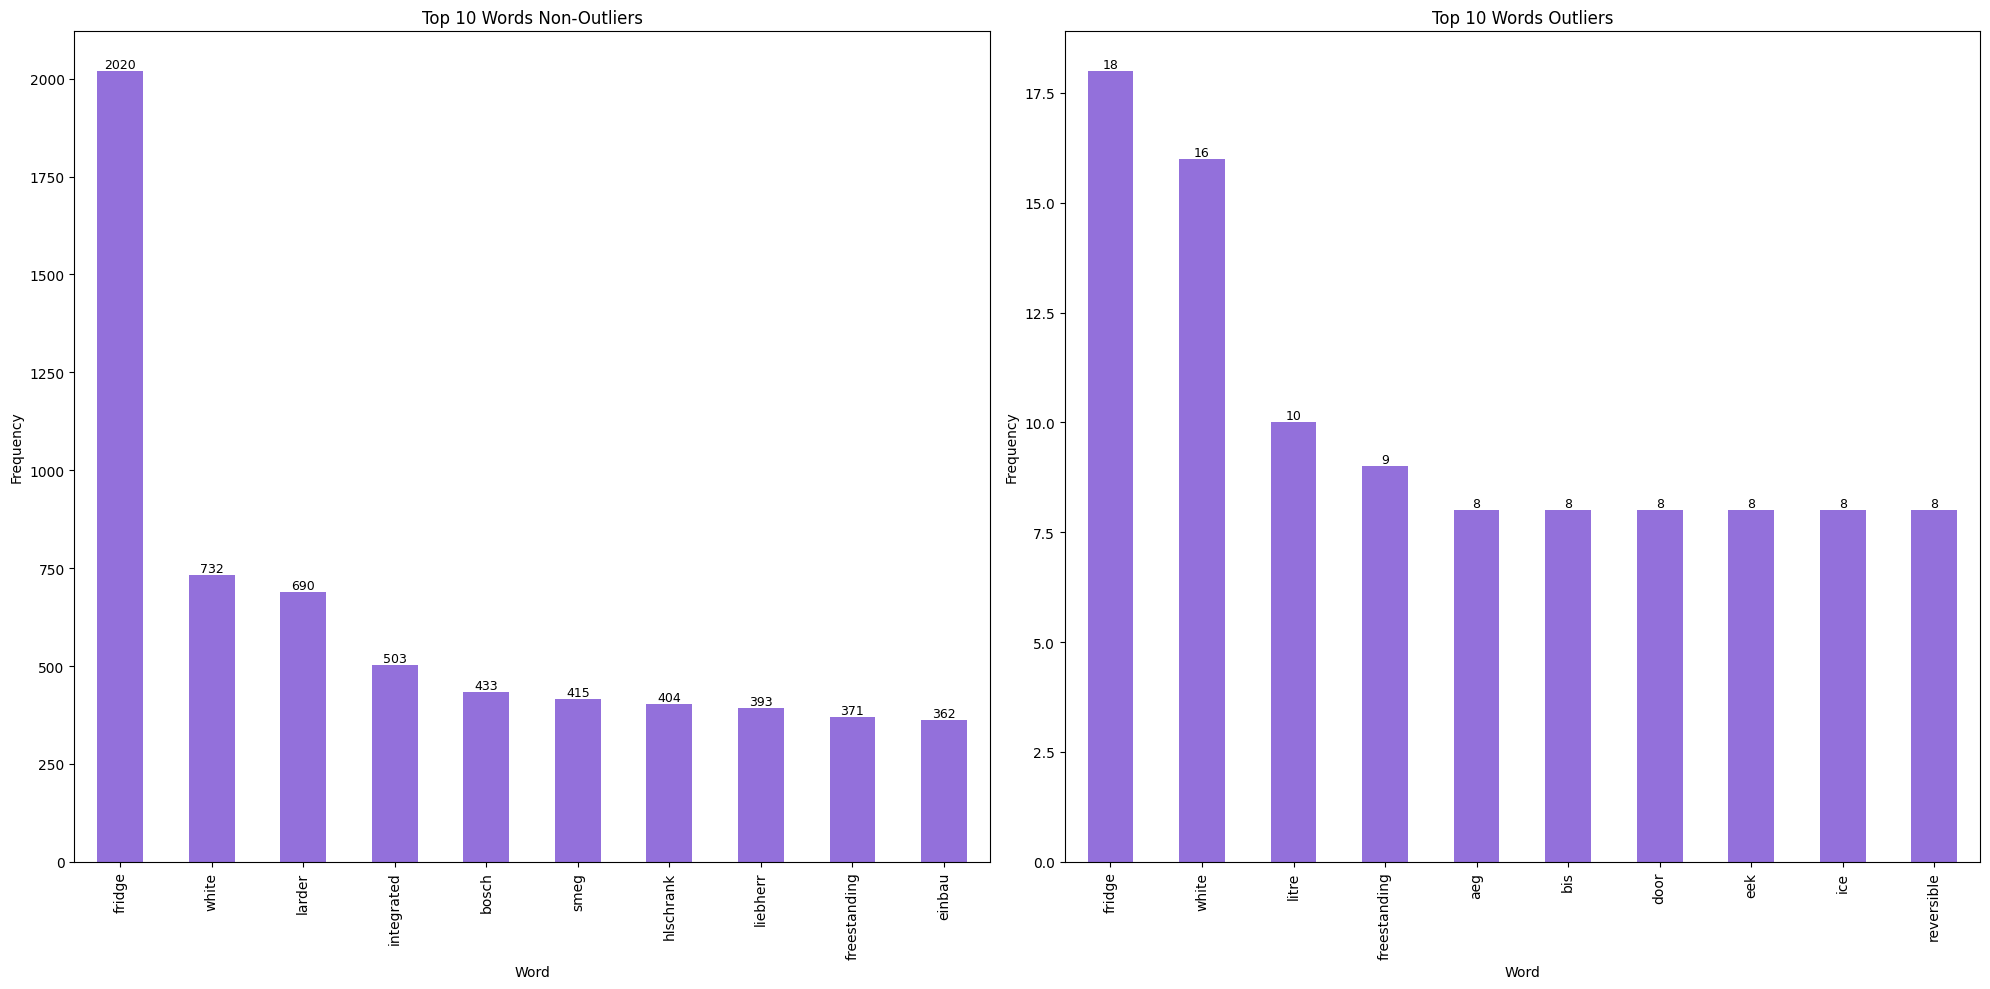

In [44]:
top_10_words('Fridges', outliers_df, nonoutliers_df)

#### Microwaves Top 10 Words Outlier vs. Non-Outlier

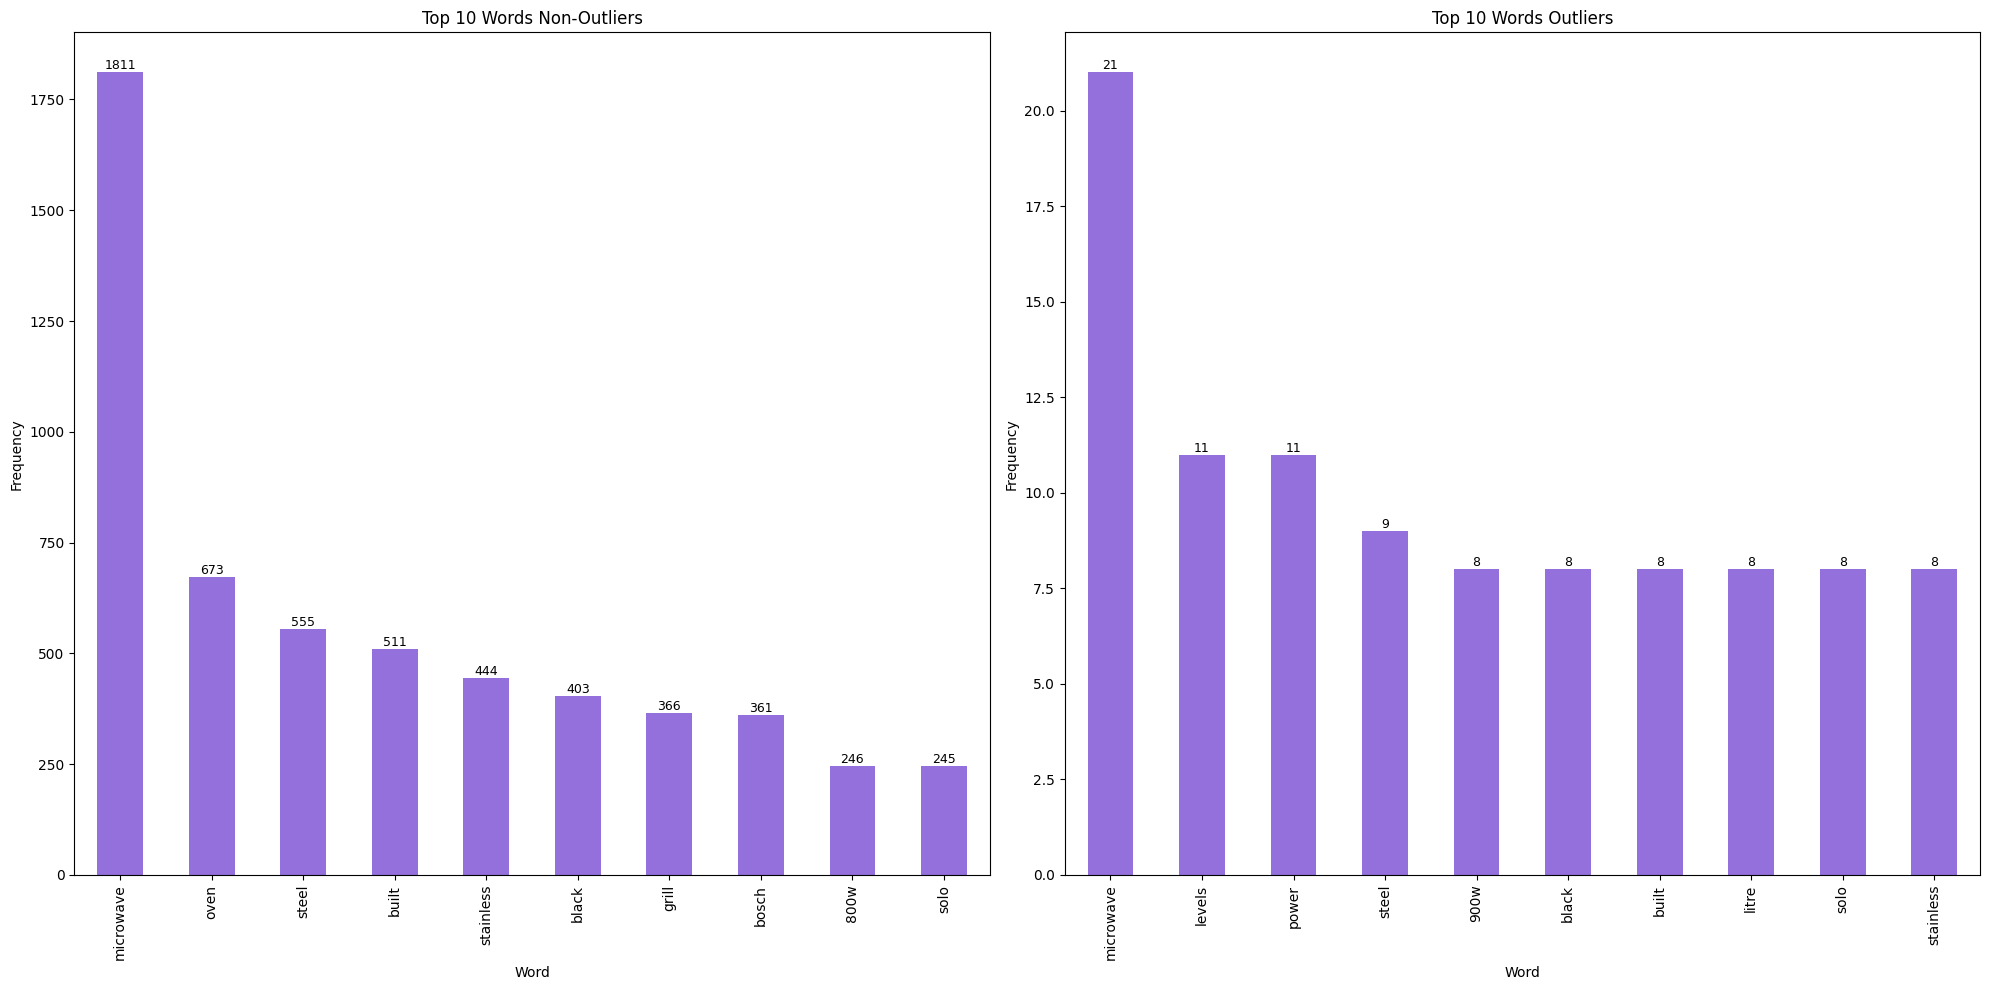

In [45]:
top_10_words('Microwaves', outliers_df, nonoutliers_df)

#### Mobile Phones Top 10 Words Outlier vs. Non-Outlier

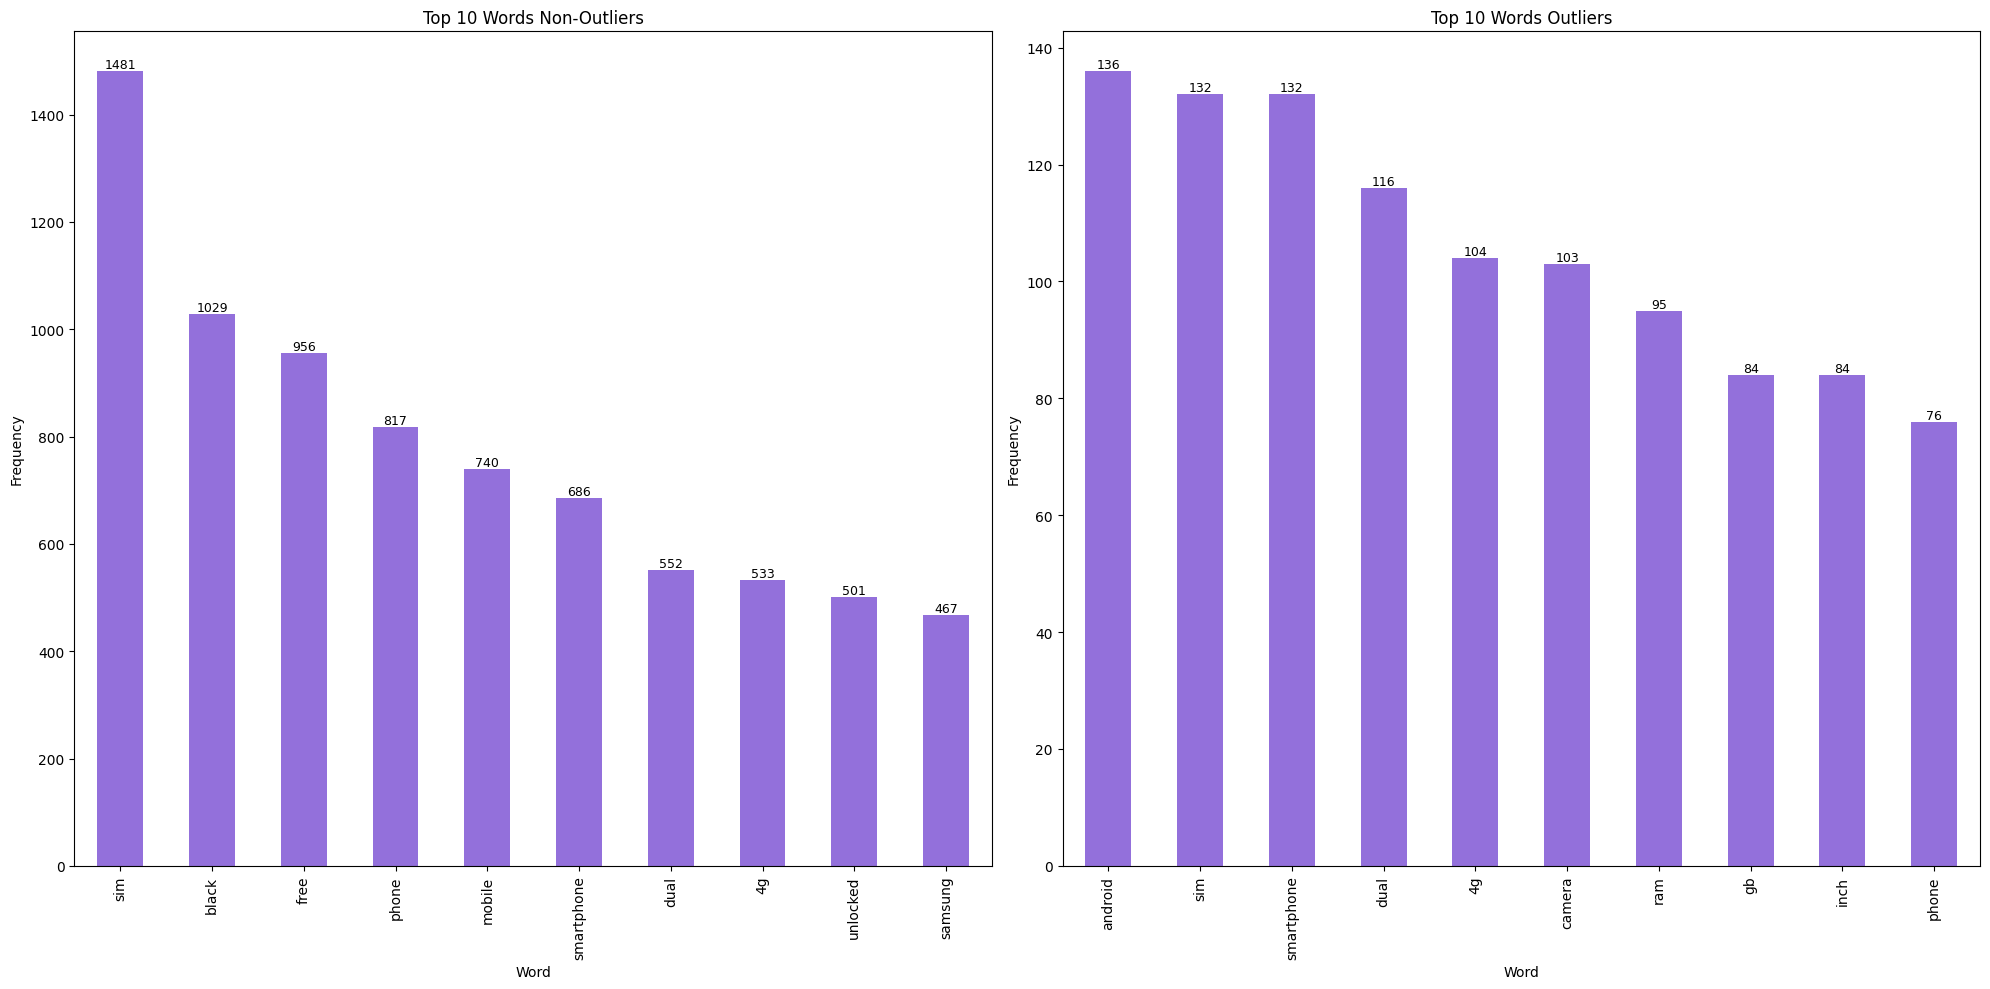

In [46]:
top_10_words('Mobile Phones', outliers_df, nonoutliers_df)

#### TVs Top 10 Words Outlier vs. Non-Outlier

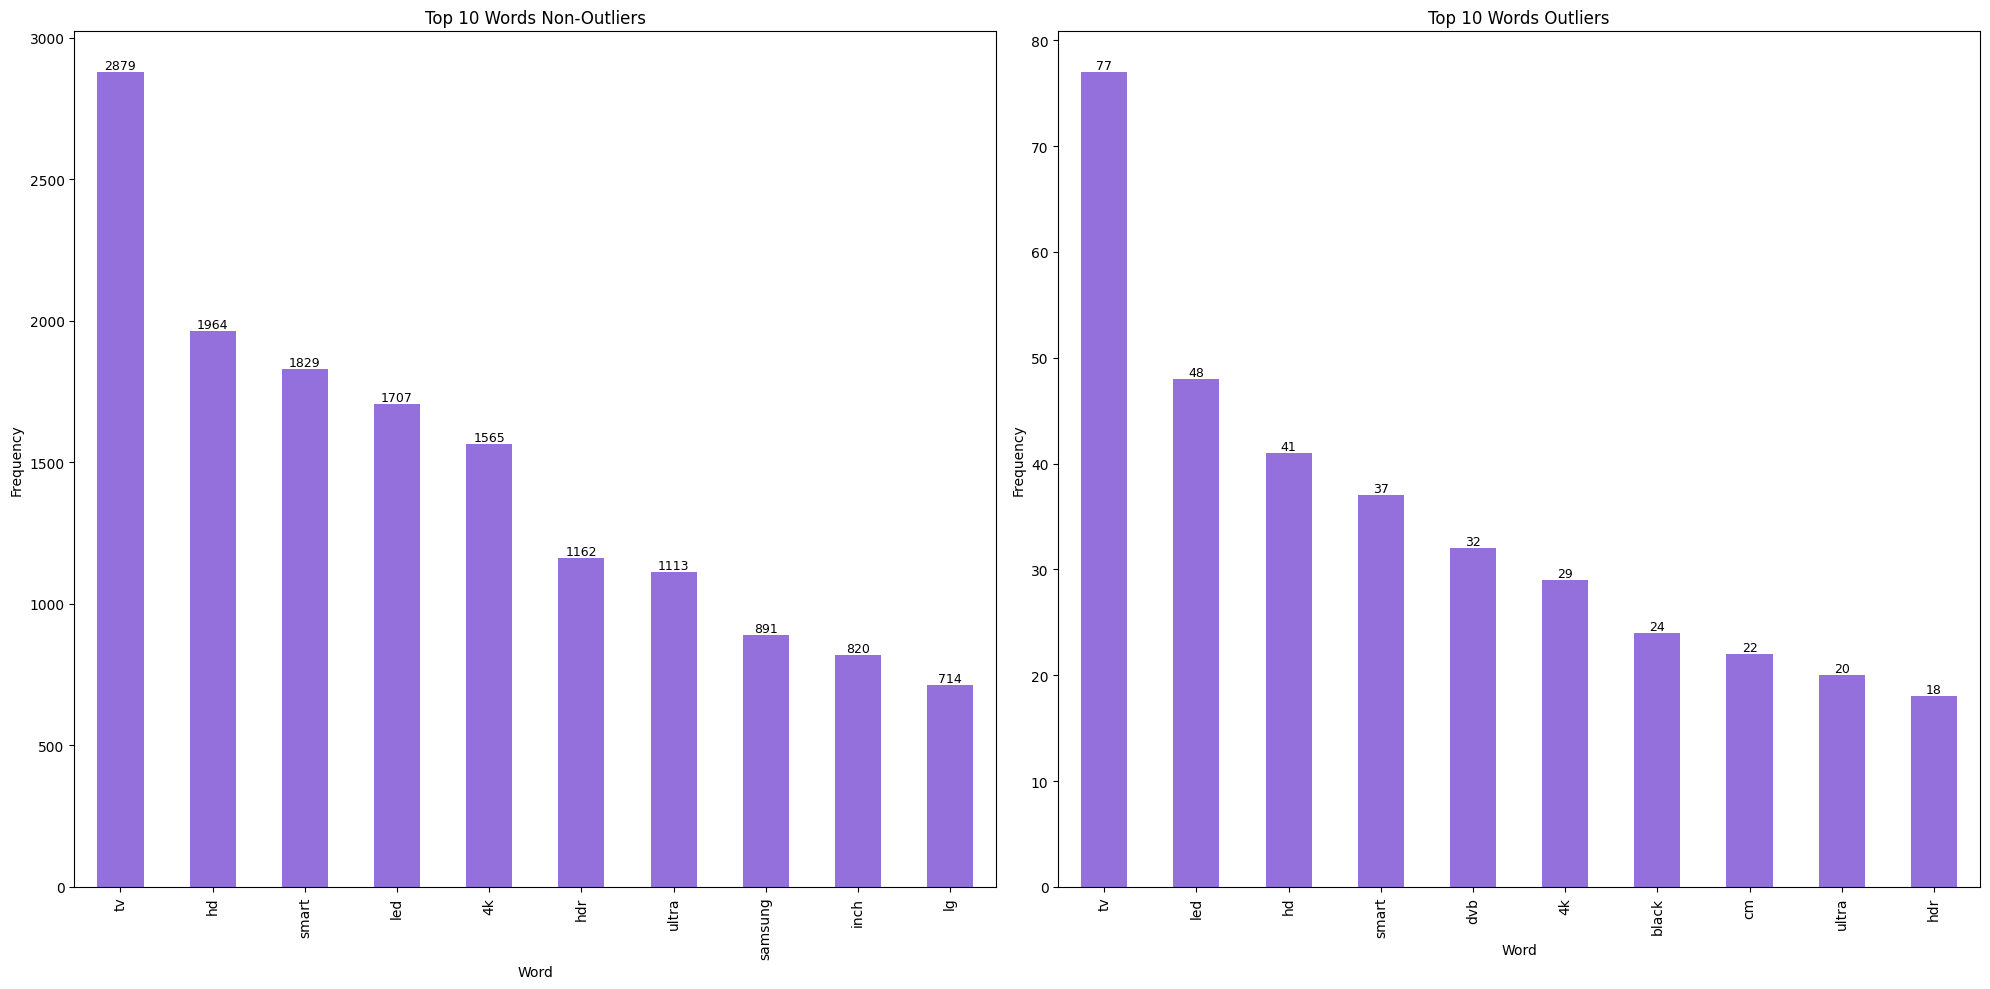

In [47]:
top_10_words('TVs', outliers_df, nonoutliers_df)

#### Washing Machines Top 10 Words Outlier vs. Non-Outlier

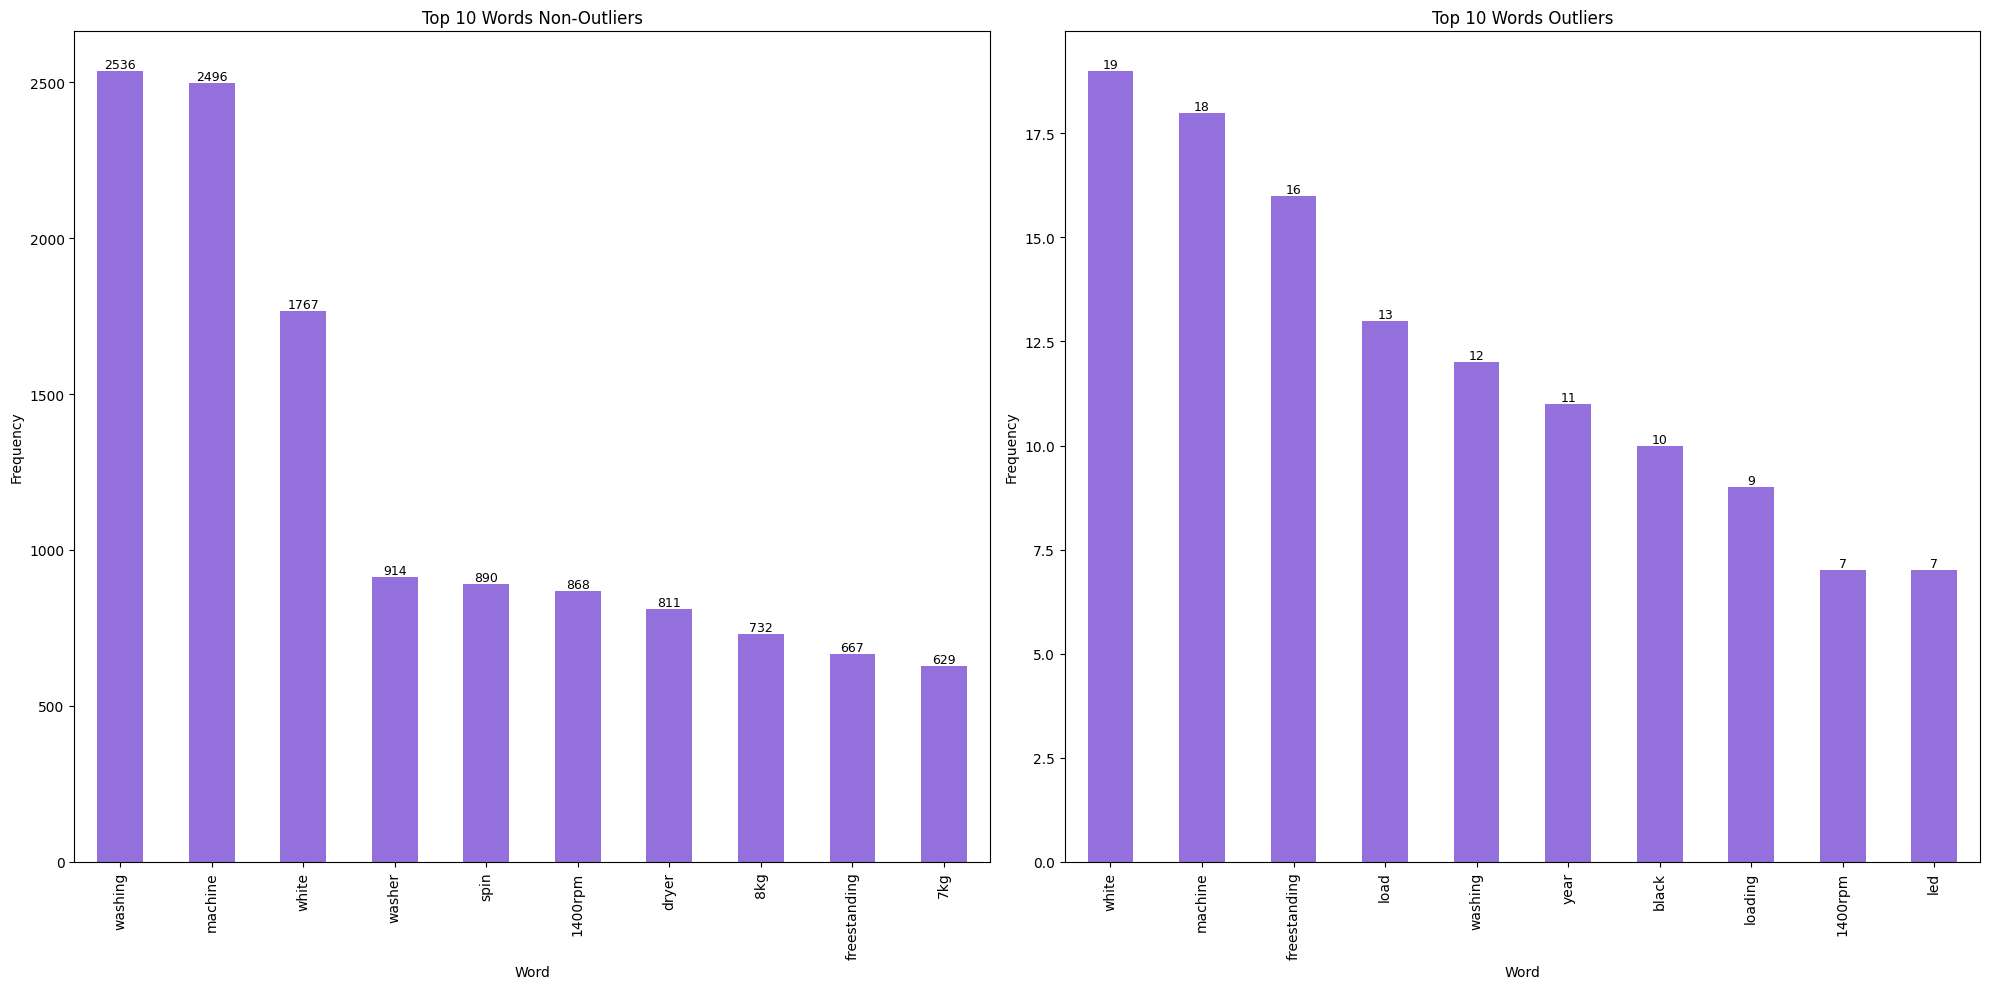

In [48]:
top_10_words('Washing Machines', outliers_df, nonoutliers_df)

#### Top 10 Words Summary

By removing stopwords, we’re able to more clearly highlight the differences in language used between non-outlier and outlier product titles across categories.

- CPUs: There’s strong overlap between groups, with both emphasizing hardware features. While the exact words differ, the focus remains technical across both sets.

- Dishwashers: Significant overlap exists, but color appears as a differentiator—“white” shows up in non-outliers, while “stainless” and “steel” appear in outliers.

- Digital Cameras: Both groups highlight camera features, but outliers emphasize specifics like “compact” and “zoom.” “Canon” appears in non-outliers but not outliers, suggesting outlier cameras may come from alternative brands.

- Freezers: Brand differences emerge—“bosch” appears in non-outliers, while “russell” and “hobbs” are prominent in outliers.

- Fridge Freezers: “American” appears in non-outliers, possibly referencing style or origin, while outliers mention the brand “liebherr” and the color “white.”

- Fridges: Non-outliers highlight brands; outliers focus more on basic appliance features.

- Microwaves: Word use is similar. “Grill” and “oven” show up in non-outliers, while “power” and “900w” appear in outliers.

- Mobile Phones: The biggest difference lies in phone type. “Samsung” is prominent in non-outliers, whereas “android” features in outliers, suggesting broader or more generic references.

- TVs: Top words are nearly identical, indicating little variation between the two groups.

- Washing Machines: Outliers include terms like “year,” “load,” and “LED,” while non-outliers highlight specs like “8kg,” “7kg,” and “spin.”


### EDA Summary

Through the EDA process, we were able to determine:
- Fridge Freezer category makes up the largest proportion in the dataset, over double the smallest category, Freezers.
- The spread for average word count is roughly 5.6 with approximately 12.4 words on average for the CPU category and 6.8 words on average for the dishwashers category.
- The most common words within categories often align to the category names themselves and when they don't it is still easy to attribute the term to its category. 
- The vast majority of outliers for categories appear to be on the high end of word count. 
- Through the outlier exploration, we were able to confirm that mobile phones had the most outliers from an absolute count, but only 4.5% of their Product Titles were outliers. Likewise, Merchant 3 is overrepresented in the outlier data purely because they sell more products.
- By comparing the outliers vs. non-outliers by category, we were able to see that not only was the average word count higher, but the unique word ratio was higher too. Leading us to believe that the word choices themselves are different between groups.
- By removing the stopwords and comparing the top 10 words, we could see that the majority of the top 10 words were the same across outliers and non-outliers within the category. Where they differed was often in brands or specifications.

# Preprocessing

During exploratory data analysis we observed the presence of stopwords in the Product Titles. To create a cleaner and more meaningful dataset for clustering, we will remove the stopwords during the pre-processing phase. This step will be done during the transformation of the text data into numerical features using the Term Frequency-Inverse Document Frequency score. TF-IDF is well suited for this task because it penalizes the terms that are most common across many Product Titles and highlights words that are rarer. By applying TF-IDF, we aim to emphasize meaningful terms that contribute to clearer and more representative clusters.

In [49]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)  
    text = re.sub(r'\b\d{4,}\b', '', text)   
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [50]:
product_data['clean_title'] = product_data['Product Title'].apply(clean_text)

During the exploratory data analysis process, we noticed some brand words that we were not familiar with. This led us to consider the fact that that this data set may include product titles written in other languages. If this were the case, this could significantly impact the clustering and topic modeling results. We will test this theory by sampling the data and using the langdetect library to determine if any of the samples aren't in English.

In [51]:
sample = product_data['clean_title'].sample(500, random_state=42)
sample_langs = sample.apply(lambda x: detect(x) if isinstance(x, str) else 'unknown')
print(sample_langs.value_counts())

clean_title
en    291
de     47
da     39
it     22
sv     19
ca     16
af     11
cy      9
fr      9
tl      6
nl      4
id      4
sl      3
pl      3
cs      3
et      3
sw      3
sk      2
lt      2
lv      1
hu      1
pt      1
es      1
Name: count, dtype: int64


There appears to be some German words in the dataset, these could be brands or models so we may not want to remove them. We will visually inspect the results as well as the next 2 highest languages - Danish and Italian.

In [52]:
sample_df = sample.to_frame(name='text')
sample_df['language'] = sample_df['text'].apply(lambda x: detect(x) if isinstance(x, str) else 'unknown')

In [53]:
print(sample_df[sample_df['language']=='de'].head())
print(len(sample_df[sample_df['language']=='de']))

                                                 text language
16429                   mikrowellenger t mwg cb weiss       de
34193  neff kl 225 a einbau k hlger t mit gefrierfach       de
26014                bosch gsn29dw3p gefrierschrank a       de
34963               aeg einbau k hlschrank skb51021as       de
34873           amica stand k hlschrank wei vks15460w       de
46


In [54]:
print(sample_df[sample_df['language']=='da'].head())
print(len(sample_df[sample_df['language']=='da']))

                                                    text language
32130         bosch serie 4 kil22vf30g integrated fridge       da
32450     cda fw223 integrated built under larder fridge       da
30743  neff ksa 778 a1 side by side k hlschrank ka790...       da
29223                 beko csg1582b fridge freezer black       da
31073          indesit ld70n1s wtd fridge freezer silver       da
35


In [55]:
print(sample_df[sample_df['language']=='it'].head())
print(len(sample_df[sample_df['language']=='it']))

                                                    text language
19949                                        caple di465       it
10035  intel core i7 processor 320 ghz 12 mb smart cache       it
7998   intel core i7 6850k s2011 v3 360ghz 6 core 15m...       it
10761  hewlett packard enterprise intel xeon e5630 25...       it
2532                  motorola tesco mobile moto c black       it
21


Based on these results, it is safe to say that there are German phrases within our dataset. Because these German words may actually be signalling category information, we are going to remove these rows from the dataset. For example a word may be the German word for dishwasher, but our algorithm would not know to then group it with the English dishwasher cluster. The Danish and Italian results are much less cut and dry, however they makup such a small portion of the sample we will go ahead and remove all non-English results.

Since our initial results were just a sample, we will apply a function to the entire 'clean_title' column of the product data and the subset the dataset to those that are considered to be written in English.

In [56]:
langdetect.DetectorFactory.seed = 42

def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return 'unknown'

In [57]:
product_data['language'] = product_data['clean_title'].apply(detect_language)

In [58]:
product_data = product_data[product_data['language'] == 'en']

In [59]:
product_data.shape

(20686, 10)

The process of removing the non-English product titles reduced the dataset to 20,686 records vs. the original 35,311 records. We are going to take one more step in the pre-process phase and create a cusotm stopword list. We noticed during exploratory data analysis that words like 'a' were included in the product title descriptions and were often found in the outliers. In addition, we are concerned that there may be other terms that are found across the categories and as a result will inhibit the best clustering and topic modeling results. We aim to take a somewhat conservative approach in generating the custom stopword list by only including those terms that are either of length 1, are solely a digt (64 would be removed but 64GB would not) or are found in all 10 categories. This is to prevent removing too many terms that may in fact be useful in clustering and topic modeling. 

To begin this process, we will build a function that uses the clean_title description column and counts the words and how many categories the word is in as well as it's total count. We will then build a dataframe to be used for the filtering off of those previously mentioned terms that are either of length 1, a digit, or appear in all 10 categories. This new custom stop word list will be used with the standard English stopwords to create one custom stopword list fed to the TfidfVectorizer. We will also initially set the max_features to 5000 to futher limit the resulting matrix. 

In [60]:
word_category_counts = defaultdict(set)

for _, row in product_data.iterrows():
    category = row['Category Label']
    words = row['clean_title'].split()
    for word in words:
        word_category_counts[word].add(category)

word_cat_df = pd.DataFrame([
    (word, len(cats)) for word, cats in word_category_counts.items()
], columns=['word', 'category_count'])

common_df = pd.DataFrame(Counter(' '.join(product_data['clean_title']).split()).items(), columns=['word', 'total_count'])
merged = common_df.merge(word_cat_df, on='word')
merged = merged.sort_values(by=['category_count', 'total_count'], ascending= [False, False])

In [61]:
merged.head()

,word,total_count,category_count
11,in,3873,10
28,black,2574,10
93,with,2445,10
188,a,2410,10
213,4,969,10


In [62]:
filtered_words = merged[
    (merged['word'].str.len() == 1) |                  
    (merged['word'].str.isdigit()) |                   
    (merged['category_count'] >= 10)    
] 
filtered_words = filtered_words.sort_values(by='total_count', ascending=False)
dataset_stopwords = filtered_words['word'].tolist()
custom_stopwords = list(text.ENGLISH_STOP_WORDS.union(dataset_stopwords))
len(custom_stopwords)

813

In [63]:
vectorizer = TfidfVectorizer(stop_words=custom_stopwords, max_features = 5000)

X = vectorizer.fit_transform(product_data['clean_title'])
X.shape

(20686, 5000)

# Model Building

Now that we've finished the preprocessing, we will begin our model building process by building a KMeans cluster and examine the results. Since we know that there are 10 categories, we will start with 10 clusters and depending on the results, tune the parameters from there. 

To evaluate the KMeans results we will be using two metrics: the accuracy score and adjusted rand index. Because we have the true labels, we are able to compare the predicted results to the true results and will calculate the accuracy score and adjusted rand index in this manner. We would expect at least an accuracy score of 0.7 (70%) to be considered a good model, but ideally we will be in the 90% range. Similarly, we would like an adjusted rand index of at least 0.7 to be considered a good model.

## KMeans Clustering Algorithm

Initialize the model with n_clusters = 10

In [64]:
kmeans = KMeans(n_clusters=10, random_state=42)

Fit the Model

In [65]:
kmeans.fit(X)

labels = kmeans.labels_  

In [66]:
encoder = LabelEncoder()
true_labels = encoder.fit_transform(product_data['Category Label'])

In [67]:
def label_permute_compare(y_true, y_pred):

    cm = confusion_matrix(y_true, y_pred) 
    row_ind, col_ind = linear_sum_assignment(-cm)
    mapping = dict(zip(col_ind, row_ind))
    reorder_yp = np.array([mapping[label] for label in y_pred])
    acc = accuracy_score(y_true, reorder_yp)
    return mapping, acc


In [68]:
mapping, acc = label_permute_compare(true_labels, labels)
ari = adjusted_rand_score(true_labels, labels)

print(f"Clustering Accuracy (after remap): {acc:.4f}")
print(f"Adjusted Rand Index (ARI): {ari:.4f}")

Clustering Accuracy (after remap): 0.6516
Adjusted Rand Index (ARI): 0.4286


## Find Optimal Clusters with Elbow Method
Our initial results of 10 clusters gave us an accuracy score of 0.6516 and an Adjusted Rand Index of 0.4286. Neither of which are in the range we are looking for. We are going to use the elbow method to determine if the inital 10 clusters are the optimal amount.

In [93]:
inertias = []

for k in range(2, 21):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X)
    
    train_labels = km.labels_

    inertias.append(km.inertia_)
    


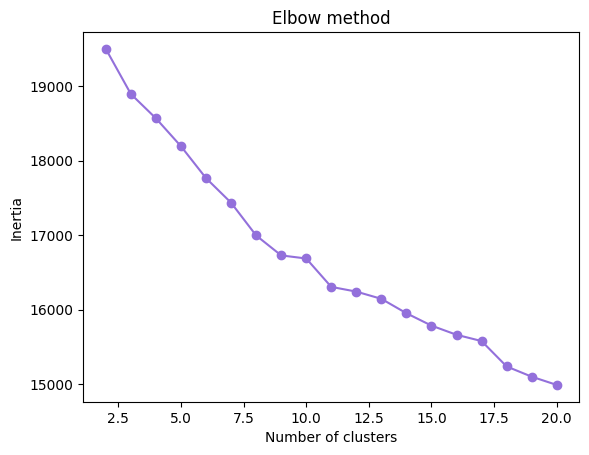

In [94]:
plt.plot(range(2, 21), inertias, marker='o', color='#9370db')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

Based on the results of the plot, n_clusters = 8 seems to be a better starting point from a compactness standpoint. However, we know that there are truly 10 product categories, we will proceed with 10 clusters for consistency in evaluation. The fact that KMeans favors 8 clusters likely reflects the overlapping of terms in certain categories, such as "Fridge Freezers", "Freezers" and "Fridges" which may grouped together due to the shared terminology.

## Hyperparameter Tuning

To address the aforementioned issue of overlapping terminology, we will begin hyperparameter tuning phase by adjusting the ngram_range to ngram_range = (1,2) in our TF-IDF vectorization. This adjustment allows the model to distinguish between terms like "fridge freezer" and individual words like "fridge" or "freezer", which could help the clustering algorithm more accurately separate overlapping categories.

In [71]:
vectorizer = TfidfVectorizer(stop_words=custom_stopwords,max_features = 5000, ngram_range=(1, 2))

X = vectorizer.fit_transform(product_data['clean_title'])

kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(X)
labels = kmeans.labels_  
mapping, acc = label_permute_compare(true_labels, labels)
ari = adjusted_rand_score(true_labels, labels)

print(f"Clustering Accuracy (after remap): {acc:.4f}")
print(f"Adjusted Rand Index (ARI): {ari:.4f}")

Clustering Accuracy (after remap): 0.6336
Adjusted Rand Index (ARI): 0.4049


Increasing ngram_range to consider bigrams seemed to decrease the accuracy of the clusters. However, we will investigate these relationships further by tuning the max_feat and ngram parameters in order to see if we can optimize the KMeans clusters more.

In [72]:
for max_feat in [500, 1000, 2000, 5000]: 
    for ngram in [(1,1), (1,2)]:
        
        vectorizer = TfidfVectorizer(
            stop_words=custom_stopwords,
            max_features=max_feat, 
            ngram_range= ngram
        )
        X = vectorizer.fit_transform(product_data['clean_title'])

        kmeans = KMeans(n_clusters=10, random_state=42)
        labels = kmeans.fit_predict(X)

        mapping, acc = label_permute_compare(true_labels, labels)
        ari = adjusted_rand_score(true_labels, labels)

        print(f"max_feat={max_feat}, ngram_rage= {ngram},acc={acc:.4f}, ARI={ari:.4f}")

max_feat=500, ngram_rage= (1, 1),acc=0.6416, ARI=0.5311
max_feat=500, ngram_rage= (1, 2),acc=0.7529, ARI=0.6355
max_feat=1000, ngram_rage= (1, 1),acc=0.6431, ARI=0.5001
max_feat=1000, ngram_rage= (1, 2),acc=0.6176, ARI=0.4924
max_feat=2000, ngram_rage= (1, 1),acc=0.6345, ARI=0.4780
max_feat=2000, ngram_rage= (1, 2),acc=0.4660, ARI=0.2418
max_feat=5000, ngram_rage= (1, 1),acc=0.6516, ARI=0.4286
max_feat=5000, ngram_rage= (1, 2),acc=0.6336, ARI=0.4049


## KMeans Results & Analysis

Our best model for KMeans is max_features = 500 and ngram_range=(1,2). We will refit that model in order to inspect the confusion matrix.

In [95]:
max_features = 500
ngram_range = (1,2)

vectorizer = TfidfVectorizer(stop_words=custom_stopwords,max_features = max_features,  ngram_range = ngram_range)
X = vectorizer.fit_transform(product_data['clean_title'])

kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(X)
labels = kmeans.labels_  
reordered_labels = np.array([mapping[label] for label in labels])  

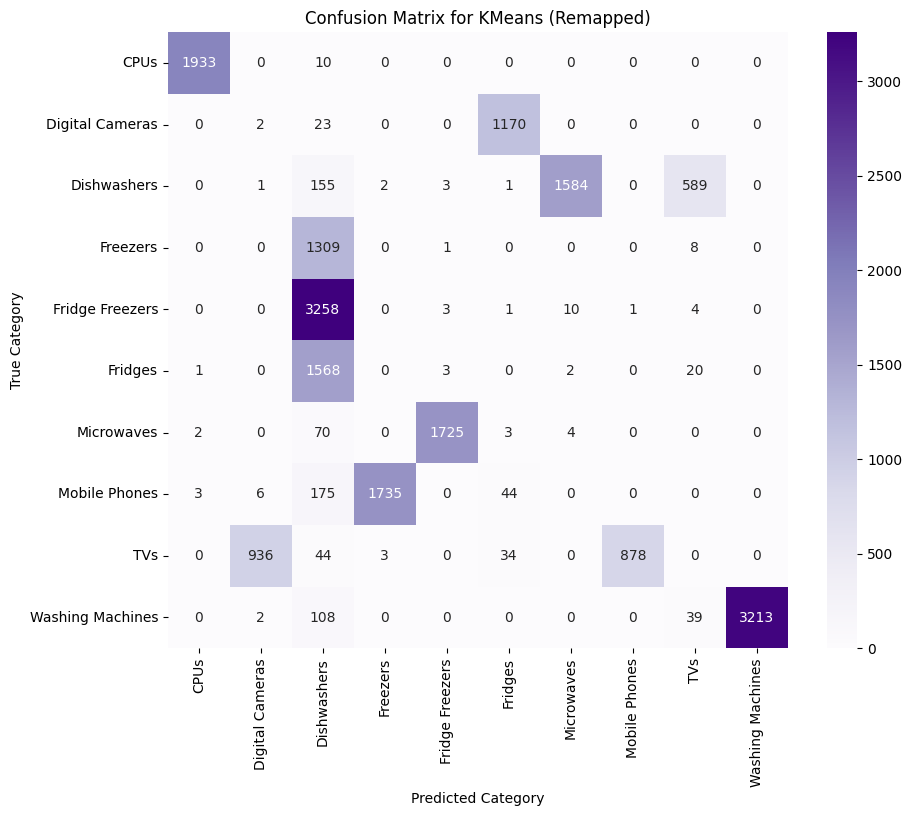

In [96]:
cm = confusion_matrix(true_labels, reordered_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel("Predicted Category")
plt.ylabel("True Category")
plt.title("Confusion Matrix for KMeans (Remapped)")
plt.show()

A capped vocabulary size (max_features) of 500 words with bigrams produced the strongest results with KMeans. This combination allowed us to be above 70% in accuracy at 75.29%, while we improved the adjusted rand index to 0.6355, we did not meet the threshold of 0.70. In addition, by inspecting the confusion matrix of our best model, we can see that these results are still far from ideal with issues across the board of inaccurate predictions, even among categories that you would not expect. We are interested in determining if better results may be reached with an alternative unsupervised learning algorithm, Topic Modeling.

# Topic Modeling 
We will attempt to improve our results using non-negative matrix factorization. nnsvd has been prechosen as it is better with sparse data per the documentation. We will begin by using the same best TFIDF vectorizer with max_features = 500, bigrams as well as the custom stopwords vectorizer for the topic model.

To evaluate the results, we will be using accuracy score again so that we can have a direct comparison with KMeans as well as doing a visual inspection of the resulting topics.

In [75]:
vectorizer = TfidfVectorizer(stop_words=custom_stopwords, max_features = 500, ngram_range = (1,2))
vectorizer.fit(product_data['clean_title'])
tfidf_train = vectorizer.transform(product_data['clean_title'])

print(tfidf_train.shape)

(20686, 500)


In [76]:
n_components = 10
NMF_model = NMF(n_components=n_components, init='nndsvd', random_state=42)
W_train = NMF_model.fit_transform(tfidf_train)
H_train = NMF_model.components_

In [77]:
vocabulary = vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(H_train):
    print(f"Topic #{topic_idx}:")
    top_words_idx = topic.argsort()[-10:][::-1]
    top_words = [vocabulary[i] for i in top_words_idx]
    print(", ".join(f"'{word}'" for word in top_words))

Topic #0:
'fridge', 'freezer', 'fridge freezer', 'white', 'freezer white', 'freestanding', 'liebherr', 'freestanding fridge', 'integrated fridge', 'american'
Topic #1:
'washing', 'machine', 'washing machine', 'machine white', 'white', 'spin', '1400rpm', '9kg', '8kg', 'spin washing'
Topic #2:
'dishwasher', 'integrated', 'integrated dishwasher', 'fully', 'fully integrated', 'place', '60cm', 'smeg', 'dishwasher white', 'slimline'
Topic #3:
'tv', 'hd', 'smart', 'led', '4k', 'hdr', 'inch', 'ultra', 'led tv', 'ultra hd'
Topic #4:
'cache', 'intel', 'ghz', 'core', 'mb', 'socket', 'xeon', 'intel xeon', 'mb cache', 'threads'
Topic #5:
'microwave', 'steel', 'stainless', 'stainless steel', 'oven', 'microwave oven', 'built', 'built microwave', 'grill', 'microwave grill'
Topic #6:
'sim', 'sim free', 'free', 'smartphone', 'phone', 'mobile', 'mobile phone', 'unlocked', 'free smartphone', 'dual'
Topic #7:
'washer', 'dryer', 'washer dryer', 'dryer white', 'white', 'hotpoint', 'integrated washer', 'dry',

In [78]:
topic_labels = W_train.argmax(axis=1)
mapping, acc = label_permute_compare(true_labels, topic_labels)
print("Topic Model Accuracy:", acc)

Topic Model Accuracy: 0.6804602146379194


The topic model accuracy with the same parameters as the final KMeans model dropped below our desired threshold of 0.70, so we are going to tune the parameters to see if we can improve the accuracy and results.

### Hyperparameter Tuning of Topic Model

In [79]:
results = []

for max_feat in [50, 100, 250, 500, 1000]:
    for ngram in [(1,1), (1,2)]:
        
        tfidf_vectorizer = TfidfVectorizer(max_features=max_feat, ngram_range = ngram, stop_words=custom_stopwords)

        tfidf_vectorizer.fit(product_data['clean_title'])
        
        tfidf_train = tfidf_vectorizer.transform(product_data['clean_title'])
        
        NMF_model = NMF(n_components=10, init='nndsvd', random_state=42)
        
        W_train = NMF_model.fit_transform(tfidf_train)
        H_train = NMF_model.components_
        
        topic_labels = W_train.argmax(axis=1)
        
        mapping, acc = label_permute_compare(true_labels, topic_labels)


        print(f"max_feat={max_feat}, ngram_rage= {ngram}, acc={acc:.4f}")



max_feat=50, ngram_rage= (1, 1), acc=0.7109
max_feat=50, ngram_rage= (1, 2), acc=0.7057
max_feat=100, ngram_rage= (1, 1), acc=0.7432
max_feat=100, ngram_rage= (1, 2), acc=0.7789
max_feat=250, ngram_rage= (1, 1), acc=0.6991
max_feat=250, ngram_rage= (1, 2), acc=0.7378
max_feat=500, ngram_rage= (1, 1), acc=0.6870
max_feat=500, ngram_rage= (1, 2), acc=0.6805
max_feat=1000, ngram_rage= (1, 1), acc=0.6508
max_feat=1000, ngram_rage= (1, 2), acc=0.6801


## Topic Modeling Results & Analysis

After testing a variety of options for max_features, the number that produced the best accuracy results was 100 with bigrams. It improved the accuracy not only for the topic modeling group, but also was the highest accuracy overall at 77.89%. 

Now that we've found the highest accuracy, we are going to build out the Topic Model with the max features set to 100 and bigrams in order to see if our topics make sense, ie is the human eye able to easily discern what these topics are? 

In [80]:
vectorizer = TfidfVectorizer(stop_words=custom_stopwords, max_features = 100, ngram_range = (1,2))
vectorizer.fit(product_data['clean_title'])
tfidf_train = vectorizer.transform(product_data['clean_title'])

print(tfidf_train.shape)

(20686, 100)


In [81]:
n_components = 10
NMF_model = NMF(n_components=n_components, init='nndsvd', random_state=42)
W_train = NMF_model.fit_transform(tfidf_train)
H_train = NMF_model.components_

In [82]:
vocabulary = vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(H_train):
    print(f"Topic #{topic_idx}:")
    top_words_idx = topic.argsort()[-10:][::-1]
    top_words = [vocabulary[i] for i in top_words_idx]
    print(", ".join(f"'{word}'" for word in top_words))

Topic #0:
'freezer', 'fridge', 'fridge freezer', 'frost', 'frost free', 'free', 'free fridge', 'liebherr', 'american', 'integrated'
Topic #1:
'washing', 'machine', 'washing machine', 'machine white', 'spin', '1400rpm', '8kg', '9kg', 'spin washing', 'freestanding washing'
Topic #2:
'tv', 'hd', 'smart', 'led', '4k', 'inch', 'hdr', 'led tv', 'ultra', 'ultra hd'
Topic #3:
'dishwasher', 'integrated', 'integrated dishwasher', 'place', 'fully', 'fully integrated', 'bosch', '60cm', 'dishwasher white', 'smeg'
Topic #4:
'cache', 'intel', 'core', 'processor', 'ghz', 'socket', 'mb', 'xeon', 'amd', 'intel xeon'
Topic #5:
'microwave', 'steel', 'stainless', 'stainless steel', 'built', 'oven', 'microwave oven', 'bosch', 'litre', 'digital'
Topic #6:
'sim', 'sim free', 'free', 'smartphone', 'unlocked', 'phone', 'dual', 'mobile', 'free standing', 'standing'
Topic #7:
'white', 'freezer white', 'freestanding', 'bosch', 'wide', 'freezer', 'dishwasher white', 'larder', 'serie', 'freestanding fridge'
Topic #8

Looking at the resulting topics:

-  Topic #0 appears to be pretty pure in that the terms revolve around freezers and fridges. However, we do know from the actual categories that there are three separate categories around these terms, a fridge category, a freezer category, and a fridge-freezer category. It's a bit unclear based on the top terms in this model which category this would correspond to.
-  Topic #1 looks to be completely centered around washing machines and based on the top terms seems very pure. 
-  Topic #2 centers around tv with all the top terms being very clearly tv focused.
-  Topic #3 centers around dishwashers with all the top terms being dishwasher related terms.
-  Topic #4 has terms related to computers and their hardware and likely corresponds to the known CPU category.
-  Topic #5 includes terms like "microwave", "microwave oven", and "oven" and therefore clearly aligns to the known category of microwaves.
-  Topic #6 appears to be a mix of products. There are terms that relate to mobile phones - a known category - like 'sim', 'smartphone', and 'mobile'. But then there are terms like 'free standing' and 'standing' whihc usually refer to an appliance like a fridge not a mobile phone.
-  Topic #7 this topic also seems to be a mix of topics with terms like freezer, freestanding and dishwasher included.
-  Topic #8 terms at first appear to be focused on digital cameras with terms like 'camera', 'lens' and 'digital', however as we move down the list the terms start to be ones related to mobile phones like 'phone' 'mobile' and 'smartphone'. 
-  Topic #9 is focused on terms related to washer and dryers and while it appears to be pure when looking at the top words, it does create second category of washers and dryers as topic #1 was also focused on those products. 

# Model Summary

The best KMeans clustering had an accuracy rating of acc=0.7529, with the 500 max features and bigrams. While the accuracy rating was good, the adjusted rand index did not reach the desired threshold and the confusion matrix showed there were still quite a few incorrectly predicted categories. 

As a result, we chose to see if we could improve the performance with Topic Modeling. By tuning the hyperparameters, we were able to improve the accuracy rating to 0.7789 by using 100 max features and bigrams. By visually inspecting the top 10 words for the formed topics, we were able to determine that again, while the accuracy was good, there was still room for improvement. There were topics that were not pure in that they included terms related to multiple categories, in addition, there topics that were pure but were essentially duplicates of another topic. In the end, while the topic model did have the best accuracy results and exceeded the bare minimum threshold we set of 70% accuracy, we were not able to reach our ideal state of 90% accuracy (or more) and this showed in the visual inspection of the topics. 

# Discussion & Conclusion

Even though the data was much cleaner than we had expected, preprocessing was still not a quick step. Building a text matrix for unsupervised learning tasks involves many additional steps,even with clean data,and these steps can greatly impact the results.

While both algorithms performed relatively well, I had hoped that using a custom stop word list and limiting the dataset to product titles most likely in English would have resulted in even stronger peformance. Even so, these steps were important to improving the overall quality of the resulting clusters. 

If we were to extend this project further, we might try a blended approach: starting with 8 broader topic models and then splitting the topic that likely contains freezers, fridges and fridge-freezers into three subcategories. The reasoning behind this being that freezers, fridge-freezers and fridges are essentially variations of the same product, and the unsupervised learning approaches used might group them together. 

We could also extend this project by attempting to cluster individual product items themselves, similar to the approach used originally on the dataset. This would allow for more granular insights than the current grouping by category.